In [1]:
import pandas as pd                         # 데이터 분석 라이브러리
import numpy as np                          # 계산 라이브러리
from tqdm import tqdm                       # 진행바
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.model_selection import KFold   # K-fold CV    
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings                   
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore") 
import multiprocessing
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns   
from sklearn.cluster import KMeans

In [2]:
!pip install catboost

     |████████████████████████████████| 64.4 MB 68 kB/s  eta 0:00:01
     |████████████████████████████████| 7.1 MB 57.6 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11430 sha256=b92367aab8c3b7fa3df652d467a55229d1bc241b3d50d919090d238b5756e836
  Stored in directory: /home/gunwook/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [3]:
train = pd.read_csv('/home/gunwook/train.csv')
#test = pd.read_csv('test.csv')

In [7]:
train

,game_id,winner,time,player,species,event,event_contents
0,0,1,0.00,0,T,Camera,"at (145.25, 21.5078125)"
1,0,1,0.00,1,T,Camera,"at (22.75, 147.0078125)"
2,0,1,0.02,0,T,Selection,['OrbitalCommand [3080001]']
3,0,1,0.02,0,T,Ability,(1360) - TrainSCV
4,0,1,0.14,0,T,Camera,"at (142.99609375, 24.50390625)"
...,...,...,...,...,...,...,...
67091771,38871,0,8.51,0,Z,Camera,"at (139.578125, 62.58203125)"
67091772,38871,0,8.52,1,T,GetControlGroup,NaN
67091773,38871,0,8.52,0,Z,Camera,"at (122.42578125, 45.4296875)"
67091774,38871,0,8.52,0,Z,Camera,"at (122.42578125, 43.25390625)"


In [60]:
find = train[train['game_id'] == 30000]

In [61]:
find = find[find['player'] == 0]

In [62]:
cam1 = find[find['event'] == 'Camera']

In [64]:
cam1

,game_id,winner,time,player,species,event,event_contents
51714655,30000,0,0.00,0,T,Camera,"at (24.75, 137.0078125)"
51714659,30000,0,0.01,0,T,Camera,"at (24.75, 136.67578125)"
51714660,30000,0,0.01,0,T,Camera,"at (25.84765625, 135.57421875)"
51714661,30000,0,0.01,0,T,Camera,"at (28.28125, 133.140625)"
51714662,30000,0,0.01,0,T,Camera,"at (29.1015625, 132.32421875)"
...,...,...,...,...,...,...,...
51716871,30000,0,7.57,0,T,Camera,"at (27.9375, 117.21484375)"
51716872,30000,0,7.57,0,T,Camera,"at (27.9375, 118.44140625)"
51716873,30000,0,7.58,0,T,Camera,"at (27.9375, 120.671875)"
51716891,30000,0,8.01,0,T,Camera,"at (27.3203125, 122.1796875)"


In [65]:
cam['event_contents'] = cam['event_contents'].str.replace('at', '')
cam['event_contents'] = cam['event_contents'].str.replace('(', '')
cam['event_contents'] = cam['event_contents'].str.replace(')', '')
cam1['event_contents'] = cam1['event_contents'].str.replace('at', '')
cam1['event_contents'] = cam1['event_contents'].str.replace('(', '')
cam1['event_contents'] = cam1['event_contents'].str.replace(')', '')

In [66]:
y = cam1['event_contents'].str.split(',')
x = cam['event_contents'].str.split(',')

In [70]:
cam_full

,game_id,winner,time,player,species,event,event_contents,x_location,y_location
51714656,30000,0,0.00,1,Z,Camera,"127.25, 27.5078125",127.250000,27.507812
51714665,30000,0,0.01,1,Z,Camera,"127.25, 28.55859375",127.250000,28.558594
51714668,30000,0,0.02,1,Z,Camera,"127.25, 29.9140625",127.250000,29.914062
51714683,30000,0,0.07,1,Z,Camera,"127.25, 29.48046875",127.250000,29.480469
51714684,30000,0,0.07,1,Z,Camera,"127.25, 28.66015625",127.250000,28.660156
...,...,...,...,...,...,...,...,...,...
51716871,30000,0,7.57,0,T,Camera,"27.9375, 117.21484375",27.937500,117.214844
51716872,30000,0,7.57,0,T,Camera,"27.9375, 118.44140625",27.937500,118.441406
51716873,30000,0,7.58,0,T,Camera,"27.9375, 120.671875",27.937500,120.671875
51716891,30000,0,8.01,0,T,Camera,"27.3203125, 122.1796875",27.320312,122.179688


In [67]:
cam1['x_location'] = y.str[0].astype('float')
cam1['y_location'] = y.str[1].astype('float')
cam['x_location'] = x.str[0].astype('float')
cam['y_location'] = x.str[1].astype('float')

In [68]:
cam_full = pd.concat([cam,cam1])

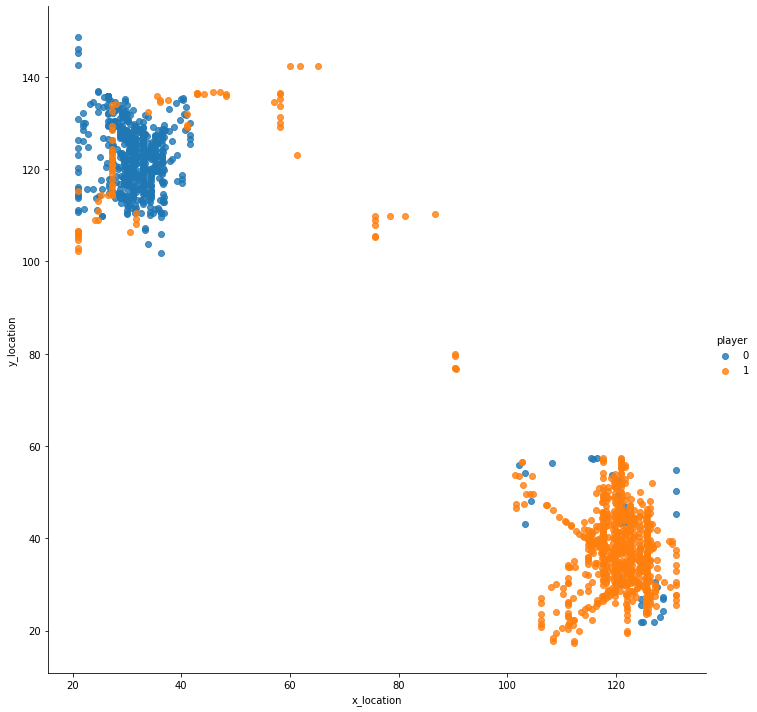

In [72]:
sns.lmplot(x = 'x_location', y = 'y_location', data = cam_full, fit_reg=False ,hue = 'player',height = 10)

# 시작한 지역 탐색

In [278]:
df_train = pd.DataFrame(train.game_id.unique(), columns=['game_id'])
df_train.index = df_train.game_id
df_train = df_train.drop(['game_id'], axis = 1)

In [279]:
df_train_p0 = train[(train.event=='Camera')&(train.player==0)]
df_train_p0 = df_train_p0[df_train_p0.shift(1).game_id!=df_train_p0.game_id] # 쉬프트를 이용하여 각 게임의 첫번째 데이터 찾기
df_train_p0 = df_train_p0.iloc[:, [0,6]].rename({'event_contents':'player0_starting'}, axis = 1)
df_train_p0.index = df_train_p0['game_id']
df_train_p0 = df_train_p0.drop(['game_id'], axis=1)
df_train = pd.merge(df_train, df_train_p0, on='game_id', how='left')
del df_train_p0

df_train_p1 = train[(train.event=='Camera')&(train.player==1)]
df_train_p1 = df_train_p1[df_train_p1.shift(1).game_id!=df_train_p1.game_id]
df_train_p1 = df_train_p1.iloc[:, [0,6]].rename({'event_contents':'player1_starting'}, axis = 1)
df_train_p1.index = df_train_p1['game_id']
df_train_p1 = df_train_p1.drop(['game_id'], axis=1)
df_train = pd.merge(df_train, df_train_p1, on='game_id', how='left')
del df_train_p1

In [280]:
df_train

,player0_starting,player1_starting
game_id,,
0,"at (145.25, 21.5078125)","at (22.75, 147.0078125)"
1,"at (140.0, 162.0078125)","at (28.0, 18.5078125)"
2,"at (151.25, 20.5078125)","at (24.75, 128.0078125)"
3,"at (127.25, 27.5078125)","at (24.75, 137.0078125)"
4,"at (36.75, 122.0078125)","at (163.25, 18.5078125)"
...,...,...
38867,"at (22.75, 147.0078125)","at (145.25, 21.5078125)"
38868,"at (28.0, 18.5078125)","at (140.0, 163.75)"
38869,"at (151.25, 20.5078125)","at (24.75, 128.01171875)"


In [281]:
df_train['player0_starting'] = df_train.player0_starting.str.split('(').str[1]
df_train['player0_starting'] = df_train.player0_starting.str.split(')').str[0]
split_xy = df_train.player0_starting.str.split(',')
df_train['player0_x'] = split_xy.str[0].astype('float')
df_train['player0_y'] = split_xy.str[1].astype('float')
del split_xy

df_train['player1_starting'] = df_train.player1_starting.str.split('(').str[1]
df_train['player1_starting'] = df_train.player1_starting.str.split(')').str[0]
split_xy = df_train.player1_starting.str.split(',')
df_train['player1_x'] = split_xy.str[0].astype('float')
df_train['player1_y'] = split_xy.str[1].astype('float')
del split_xy

In [282]:
location_p0 = df_train.loc[:, ['player0_x', 'player0_y']]
location_p0 = location_p0.rename({'player0_x':'location_x', 'player0_y':'location_y'}, axis=1)

location_p1 = df_train.loc[:, ['player1_x', 'player1_y']]
location_p1 = location_p1.rename({'player1_x':'location_x', 'player1_y':'location_y'}, axis=1)
location_p1.index += location_p0.index[-1]+1

location = pd.concat([location_p0, location_p1])
location = location.dropna()
del location_p0, location_p1

In [283]:
df_train

,player0_starting,player1_starting,player0_x,player0_y,player1_x,player1_y
game_id,,,,,,
0,"145.25, 21.5078125","22.75, 147.0078125",145.25,21.507812,22.75,147.007812
1,"140.0, 162.0078125","28.0, 18.5078125",140.00,162.007812,28.00,18.507812
2,"151.25, 20.5078125","24.75, 128.0078125",151.25,20.507812,24.75,128.007812
3,"127.25, 27.5078125","24.75, 137.0078125",127.25,27.507812,24.75,137.007812
4,"36.75, 122.0078125","163.25, 18.5078125",36.75,122.007812,163.25,18.507812
...,...,...,...,...,...,...
38867,"22.75, 147.0078125","145.25, 21.5078125",22.75,147.007812,145.25,21.507812
38868,"28.0, 18.5078125","140.0, 163.75",28.00,18.507812,140.00,163.750000
38869,"151.25, 20.5078125","24.75, 128.01171875",151.25,20.507812,24.75,128.011719


In [284]:
location

,location_x,location_y
game_id,,
0,145.25,21.507812
1,140.00,162.007812
2,151.25,20.507812
3,127.25,27.507812
4,36.75,122.007812
...,...,...
77739,145.25,21.507812
77740,140.00,163.750000
77741,24.75,128.011719


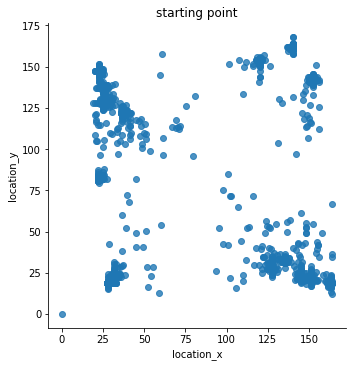

In [285]:
sns.lmplot('location_x', 'location_y', data = location, fit_reg=False)
plt.title('starting point')
plt.show()

In [286]:
df_train.player0_starting.value_counts().head(20)

24.75, 128.0078125          3123
22.75, 147.0078125          3084
145.25, 21.5078125          3072
151.25, 20.5078125          3055
152.25, 142.0078125         2716
31.75, 22.5078125           2666
24.75, 137.0078125          2612
127.25, 27.5078125          2585
163.25, 18.5078125          2446
28.0, 18.5078125            2412
140.0, 162.0078125          2355
36.75, 122.0078125          2290
135.25, 31.5078125          1225
22.25, 81.5078125           1207
120.25, 153.83984375        1202
36.74609375, 122.0078125     247
145.25, 21.51171875           64
24.75, 128.01171875           60
163.25, 18.51171875           59
28.0, 18.51171875             58
Name: player0_starting, dtype: int64

In [287]:
kmeans_clst = KMeans(n_clusters=15).fit(location)
location['starting'] = kmeans_clst.labels_+1

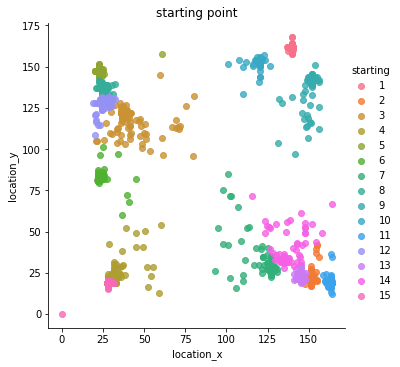

In [288]:
sns.lmplot('location_x', 'location_y', data = location, fit_reg=False, hue="starting")
plt.title('starting point')
plt.show()


In [289]:
for cluster in range(15):
    point = location[location.starting==cluster+1]
    loc = point.loc[:,['location_x', 'location_y']]
    del point
    loc['center_x'] = kmeans_clst.cluster_centers_[cluster][0]
    loc['center_y'] = kmeans_clst.cluster_centers_[cluster][1]
    distance = np.sqrt(np. square(loc.location_x - loc.center_x) + np.square(loc.location_y - loc.center_y))
    location.loc[loc.index, 'distance'] = distance
    del loc

In [290]:
idx = location[location.distance>5].index
location.loc[idx, 'starting'] = 0
del idx

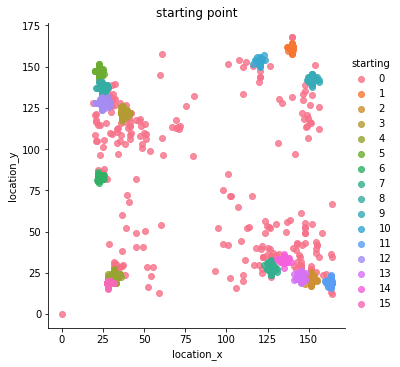

In [291]:
sns.lmplot('location_x', 'location_y', data = location, fit_reg=False, hue="starting")
plt.title('starting point')
plt.show()

In [292]:
df_train['player0_starting'] = location.loc[df_train.index, 'starting']
location.index -= (df_train.index[-1]+1)
df_train['player1_starting'] = location.loc[df_train.index, 'starting']
del location

# 불필요한 컬럼 삭제
df_train = df_train.drop(['player0_x', 'player0_y', 'player1_x', 'player1_y'], axis = 1)
df_train = df_train.fillna(0)

In [293]:
df_train

,player0_starting,player1_starting
game_id,,
0,13.0,5.0
1,1.0,15.0
2,2.0,12.0
3,7.0,8.0
4,3.0,11.0
...,...,...
38867,5.0,13.0
38868,15.0,1.0
38869,2.0,12.0


In [299]:
couple = df_train[df_train.player0_starting == 5].player1_starting.value_counts()
couple

13.0    3285
0.0        7
Name: player1_starting, dtype: int64

In [295]:
couple.index[1]

4.0

In [95]:
map_list = []
for point in range(1,16):
    couple = df_train[df_train.player0_starting == point].player1_starting.value_counts()
    if couple[couple.index[1]]<100:
        map_list.append([point, couple.index[0], 999])
    else:
        map_list.append([point, couple.index[0], couple.index[1]])
map_list = np.sort(map_list, axis = 1)
map_list = np.unique(map_list, axis = 0)

In [96]:
map_list

array([[  1.,   9., 999.],
       [  2.,   3., 999.],
       [  4.,  13., 999.],
       [  5.,  11., 999.],
       [  6.,   7., 999.],
       [  8.,  10.,  15.],
       [ 12.,  14., 999.]])

In [18]:
len(df_train[(df_train.player0_starting == 0)|(df_train.player1_starting == 0)])

258

In [97]:
for m in map_list:
    idx = df_train[(df_train.player0_starting == 0)&((df_train.player1_starting == m[0])|(df_train.player1_starting == m[2]))].index
    df_train.loc[idx, 'player0_starting'] = m[1]
    del idx
    idx = df_train[(df_train.player0_starting == 0)&((df_train.player1_starting == m[1])|(df_train.player1_starting == m[2]))].index
    df_train.loc[idx, 'player0_starting'] = m[0]
    del idx
    
    idx = df_train[(df_train.player1_starting == 0)&((df_train.player0_starting == m[0])|(df_train.player0_starting == m[2]))].index
    df_train.loc[idx, 'player1_starting'] = m[1]
    del idx
    idx = df_train[(df_train.player1_starting == 0)&((df_train.player0_starting == m[1])|(df_train.player0_starting == m[2]))].index
    df_train.loc[idx, 'player1_starting'] = m[0]
    del idx

In [98]:
df_train[(df_train.player0_starting == 0)|(df_train.player1_starting == 0)].head()

,player0_starting,player1_starting
game_id,,


In [99]:
for map_num, m in enumerate(map_list):
    idx = df_train[(df_train.player0_starting == m[0])|(df_train.player0_starting == m[1])|(df_train.player0_starting == m[2])].index
    df_train.loc[idx, 'map'] = map_num
del idx, map_list

In [100]:
df_train

,player0_starting,player1_starting,map
game_id,,,
0,5.0,11.0,3.0
1,4.0,13.0,2.0
2,14.0,12.0,6.0
3,2.0,3.0,1.0
4,6.0,7.0,4.0
...,...,...,...
38867,11.0,5.0,3.0
38868,13.0,4.0,2.0
38869,14.0,12.0,6.0


# 일꾼 수 뽑기

In [101]:
po =  train[(train['event_contents'].str.contains('TrainSCV') == True) |
            (train['event_contents'].str.contains('TrainProbe') == True) |
            (train['event_contents'].str.contains('MorphDrone') == True)]

In [102]:
count = po.groupby(['game_id','player'])['event_contents'].count()

In [103]:
worker = count.unstack().fillna(0)
worker.rename(columns = {0 : 'P0_Worker'}, inplace = True)
worker.rename(columns = {1 : 'P1_Worker'}, inplace = True)
worker.isnull().sum()

player
P0_Worker    0
P1_Worker    0
dtype: int64

# Attack 횟수 뽑기

In [104]:
po =  train[(train['event_contents'].str.contains('Attack') == True)]

In [105]:
count = po.groupby(['game_id','player'])['event_contents'].count()

In [106]:
attack = count.unstack().fillna(0)
attack.rename(columns = {0 : 'P0_Attack'}, inplace = True)
attack.rename(columns = {1 : 'P1_Attack'}, inplace = True)
attack.isnull().sum()

player
P0_Attack    0
P1_Attack    0
dtype: int64

# 전체 유닛수 뽑기 

In [107]:
po =  train[(train['event_contents'].str.contains('Train') == True) |
            (train['event_contents'].str.contains('Warp') == True) |
            (train['event_contents'].str.contains('Morph') == True)]

In [108]:
po =  po[(po['event_contents'].str.contains('MorphOverlord') == False)]

In [109]:
unit = po[po['event'] != 'Selection'].groupby(['game_id','player'])['event_contents'].count()

In [110]:
unit_all = unit.unstack().fillna(0)
unit_all.rename(columns = {0 : 'P0_count'}, inplace = True)
unit_all.rename(columns = {1 : 'P1_count'}, inplace = True)
unit_all.isnull().sum()

player
P0_count    0
P1_count    0
dtype: int64

# 전체 보급 뽑기

In [111]:
po =  train[(train['event_contents'].str.contains('BuildSupply') == True) |
            (train['event_contents'].str.contains('BuildPylon') == True) |
            (train['event_contents'].str.contains('MorphOverlord') == True)]

In [112]:
count = po.groupby(['game_id','player'])['event_contents'].count()
supply = count.unstack().fillna(0)
supply.rename(columns = {0 : 'P0_supply'}, inplace = True)
supply.rename(columns = {1 : 'P1_supply'}, inplace = True)
supply.isnull().sum()

player
P0_supply    0
P1_supply    0
dtype: int64

In [119]:
def species_converter(string):
    if string == 'T':
        return 0
    elif string == 'P':
        return 1
    elif string == 'Z':
        return 2
    else:
        raise ValueError

def data_preparation(df, answer=False):
    game_ids = df['game_id'].unique()
    events = ['Ability', 'AddToControlGroup', 'Camera', 'ControlGroup', 'GetControlGroup', 'Right Click', 'Selection', 'SetControlGroup']
    unique_event_0, unique_event_1, delta_event = {}, {}, {}
    for event in events:
        unique_event_0['P0_' + event] = 0
        unique_event_1['P1_' + event] = 0
        delta_event['delta_' + event] = 0
        
    species = df.groupby(['game_id', 'player']).species.unique()
    event_count = df.groupby(['game_id', 'player']).event.value_counts()
    if answer:
        winners = df.groupby(['game_id']).winner.max()
    
    x_data, y_data = [], []
    for game_id in tqdm(game_ids):
        df_event_count = event_count[game_id].unstack(level=-1)
        df = pd.DataFrame(species[game_id])
        df = pd.concat([df, df_event_count], axis=1)   
        df = df.fillna(0)
        
        df_P0_species = pd.DataFrame([species_converter(df.loc[0]['species'][0])], columns=['P0_species'])        
        df_P1_species = pd.DataFrame([species_converter(df.loc[1]['species'][0])], columns=['P1_species'])
        df = df.drop(['species'], axis=1)

        df_P0_event = unique_event_0.copy()
        for column in df.columns:
            df_P0_event['P0_' + column] = df.loc[0][column]
        df_P0_event = pd.DataFrame(pd.Series(df_P0_event)).T

        df_P1_event = unique_event_1.copy()
        for column in df.columns:
            df_P1_event['P1_' + column] = df.loc[1][column]
        df_P1_event = pd.DataFrame(pd.Series(df_P1_event)).T
        
        df_delta_event = delta_event.copy()
        for column in df.columns:
            df_delta_event['delta_' + column] = df_P0_event['P0_' + column][0] - df_P1_event['P1_' + column][0]
        df_delta_event = pd.DataFrame(pd.Series(df_delta_event)).T

        out = pd.concat([df_P0_species, df_P0_event, df_P1_species, df_P1_event, df_delta_event], axis=1)
        out.index = [game_id]
        out.index.name = 'game_id'
        
        x_data.append(out)
        if answer:
            y_data.append(winners[game_id])  

    x_data = pd.concat(x_data)
    y_data = np.array(y_data)
    
    return x_data, y_data

x_train, y_train = data_preparation(train, answer=True)
x_train.head()

100%|██████████| 38872/38872 [06:27<00:00, 100.42it/s]


,P0_species,P0_Ability,P0_AddToControlGroup,P0_Camera,P0_ControlGroup,P0_GetControlGroup,P0_Right Click,P0_Selection,P0_SetControlGroup,P1_species,...,P1_Selection,P1_SetControlGroup,delta_Ability,delta_AddToControlGroup,delta_Camera,delta_ControlGroup,delta_GetControlGroup,delta_Right Click,delta_Selection,delta_SetControlGroup
game_id,,,,,,,,,,,,,,,,,,,,,
0,0,34.0,2.0,444.0,0.0,24.0,35.0,50.0,3.0,0,...,57.0,1.0,0.0,2.0,19.0,0.0,21.0,7.0,-7.0,2.0
1,1,77.0,1.0,627.0,0.0,162.0,160.0,186.0,10.0,0,...,116.0,8.0,10.0,1.0,-231.0,0.0,131.0,29.0,70.0,2.0
2,1,69.0,6.0,413.0,0.0,99.0,160.0,90.0,14.0,2,...,232.0,9.0,-16.0,1.0,-312.0,-2.0,-10.0,-44.0,-142.0,5.0
3,0,82.0,0.0,713.0,0.0,132.0,276.0,180.0,6.0,1,...,148.0,19.0,-7.0,0.0,325.0,0.0,-578.0,8.0,32.0,-13.0
4,0,57.0,1.0,430.0,0.0,224.0,177.0,67.0,10.0,2,...,126.0,8.0,21.0,-3.0,158.0,0.0,125.0,71.0,-59.0,2.0


In [4]:
y_train = np.array(train[train.shift(-1).game_id != train.game_id].winner)

In [6]:
x_train['time'] = np.array(train[train.shift(-1).game_id != train.game_id].time)

In [5]:
x_train = pd.read_csv('X_train.csv',index_col = 'game_id')

In [7]:
x_train

,P0_species,P0_Ability,P0_AddToControlGroup,P0_Camera,P0_ControlGroup,P0_GetControlGroup,P0_Right Click,P0_Selection,P0_SetControlGroup,P1_species,...,delta_Attack,P0_Worker,P1_Worker,delta_Worker,P0_supply,P1_supply,delta_supply,player0_starting,player1_starting,map
game_id,,,,,,,,,,,,,,,,,,,,,
0,0,34.0,2.0,444.0,0.0,24.0,35.0,50.0,3.0,0,...,-3.0,9.0,6.0,3.0,4.0,3.0,1.0,5.0,11.0,3.0
1,1,77.0,1.0,627.0,0.0,162.0,160.0,186.0,10.0,0,...,-2.0,22.0,17.0,5.0,8.0,2.0,6.0,4.0,13.0,2.0
2,1,69.0,6.0,413.0,0.0,99.0,160.0,90.0,14.0,2,...,4.0,19.0,23.0,-4.0,5.0,7.0,-2.0,14.0,12.0,6.0
3,0,82.0,0.0,713.0,0.0,132.0,276.0,180.0,6.0,1,...,-9.0,7.0,24.0,-17.0,6.0,7.0,-1.0,2.0,3.0,1.0
4,0,57.0,1.0,430.0,0.0,224.0,177.0,67.0,10.0,2,...,12.0,14.0,13.0,1.0,2.0,4.0,-2.0,6.0,7.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38867,0,43.0,0.0,639.0,0.0,0.0,95.0,53.0,1.0,1,...,3.0,11.0,6.0,5.0,2.0,5.0,-3.0,11.0,5.0,3.0
38868,0,63.0,0.0,558.0,0.0,0.0,123.0,62.0,0.0,1,...,13.0,7.0,11.0,-4.0,3.0,1.0,2.0,13.0,4.0,2.0
38869,1,56.0,0.0,785.0,0.0,28.0,248.0,106.0,4.0,2,...,-4.0,17.0,13.0,4.0,4.0,5.0,-1.0,14.0,12.0,6.0


In [7]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38872 entries, 0 to 38871
Data columns (total 42 columns):
P0_species                 38872 non-null int64
P0_Ability                 38872 non-null float64
P0_AddToControlGroup       38872 non-null float64
P0_Camera                  38872 non-null float64
P0_ControlGroup            38872 non-null float64
P0_GetControlGroup         38872 non-null float64
P0_Right Click             38872 non-null float64
P0_Selection               38872 non-null float64
P0_SetControlGroup         38872 non-null float64
P1_species                 38872 non-null int64
P1_Ability                 38872 non-null float64
P1_AddToControlGroup       38872 non-null float64
P1_Camera                  38872 non-null float64
P1_ControlGroup            38872 non-null float64
P1_GetControlGroup         38872 non-null float64
P1_Right Click             38872 non-null float64
P1_Selection               38872 non-null float64
P1_SetControlGroup         38872 non-null flo

In [121]:
x_train = pd.merge(x_train,unit_all, on = 'game_id', how = 'left')
x_train.fillna(0,inplace= True)
x_train['delta_count'] = x_train['P0_count'] - x_train['P1_count'] 

In [122]:
x_train = pd.merge(x_train,attack, on = 'game_id', how = 'left')
x_train.fillna(0,inplace= True)
x_train['delta_Attack'] = x_train['P0_Attack'] - x_train['P1_Attack'] 

In [8]:
x_train['P0_species'] = x_train["P0_species"].astype('category')
x_train['P1_species'] = x_train["P1_species"].astype('category')
x_train['player0_starting'] = x_train["player0_starting"].astype('category')
x_train['player1_starting'] = x_train["player1_starting"].astype('category')
x_train['map'] = x_train["map"].astype('category')

In [123]:
x_train = pd.merge(x_train,worker, on = 'game_id', how = 'left')
x_train.fillna(0,inplace= True)
x_train['delta_Worker'] = x_train['P0_Worker'] - x_train['P1_Worker'] 

In [124]:
x_train = pd.merge(x_train,supply, on = 'game_id', how = 'left')
x_train.fillna(0,inplace= True)
x_train['delta_supply'] = x_train['P0_supply'] - x_train['P1_supply']

# 경기별 평균, 분산 구하기
쓸모 없고, 오히려 점수 더 떨어짐..;;

In [103]:
x_train.columns

Index(['P0_species', 'P0_AddToControlGroup', 'P0_Camera', 'P0_ControlGroup',
       'P0_GetControlGroup', 'P0_Right Click', 'P0_Selection',
       'P0_SetControlGroup', 'P1_species', 'P1_AddToControlGroup', 'P1_Camera',
       'P1_ControlGroup', 'P1_GetControlGroup', 'P1_Right Click',
       'P1_Selection', 'P1_SetControlGroup', 'delta_AddToControlGroup',
       'delta_Camera', 'delta_ControlGroup', 'delta_GetControlGroup',
       'delta_Right Click', 'delta_Selection', 'delta_SetControlGroup', 'time',
       'P0_Ability', 'P1_Ability', 'delta_Ability', 'P0_count', 'P1_count',
       'delta_count', 'P0_Attack', 'P1_Attack', 'delta_Attack', 'P0_Worker',
       'P1_Worker', 'delta_Worker', 'P0_supply', 'P1_supply', 'delta_supply'],
      dtype='object')

In [79]:
del x_train['P0_count_x']
del x_train['P1_count_x']
del x_train['P0_count_y']
del x_train['P1_count_y']

In [106]:
list1 = np.array[1,2]

In [108]:
list1 = np.array(list1)

In [110]:
list1.mean()

8.25

In [282]:
events = ['P0_AddToControlGroup','P1_AddToControlGroup',
          'P0_Camera','P1_Camera', 
          'P0_ControlGroup', 'P1_ControlGroup',
          'P0_GetControlGroup', 'P1_GetControlGroup',
          'P0_Right Click', 'P1_Right Click',
          'P0_Selection','P1_Selection',
          'P0_SetControlGroup', 'P1_SetControlGroup',
          'P0_Selection','P1_Selection',
          'P0_Ability', 'P1_Ability',
           'P0_count', 'P1_count',
          'P0_Attack', 'P1_Attack', 
          'P0_Worker', 'P1_Worker',
         'P0_supply', 'P1_supply']

In [163]:
list1 = []

In [143]:
list1.append([x_train['P0_AddToControlGroup'][0],x_train['P0_AddToControlGroup'][0]])

In [157]:
ap = np.array(list1)

In [158]:
ap

array([[444., 425.],
       [627., 858.],
       [413., 725.],
       ...,
       [785., 330.],
       [321., 385.],
       [366., 584.]])

In [162]:
ap.var(axis=1)

array([   90.25, 13340.25, 24336.  , ..., 51756.25,  1024.  , 11881.  ])

In [229]:
pd.DataFrame(ap.var(axis=1))

,0
0,90.25
1,13340.25
2,24336.00
3,26406.25
4,6241.00
...,...
38867,24806.25
38868,1406.25
38869,51756.25
38870,1024.00


In [156]:
for j in range(len(x_train)):
    list1.append([x_train['P0_Camera'][j],x_train['P1_Camera'][j]])

In [188]:
import sys
mod = sys.modules[__name__]
for i in range(10):
    setattr(mod, 'var_{}'.format(i), 4)

In [164]:
list1.append(ap.var(axis=1))

In [231]:
for i in range(0,len(events),2):
    list1 = []
    for j in range(len(x_train)):
        list1.append([x_train[events[i]][j],x_train[events[i+1]][j]])
    array = np.array(list1)
    a = pd.DataFrame(array.mean(axis = 1))
    b = pd.DataFrame(array.var(axis = 1))
    c = pd.DataFrame(array.std(axis = 1))
   # setattr(mod, '{}_mean'.format(events[i]).replace('P0_',''), array.mean(axis = 1))
    #setattr(mod, '{}_var'.format(events[i]).replace('P0_',''), array.var(axis = 1))
    #setattr(mod, '{}_std'.format(events[i]).replace('P0_',''), array.std(axis = 1))
    x_train = pd.concat([x_train , a] , axis = 1)
    x_train.rename(columns = {0 : '{}_mean'.format(events[i]).replace('P0_','')}, inplace = True)
    x_train = pd.concat([x_train , b] , axis = 1)
    x_train.rename(columns = {0 : '{}_var'.format(events[i]).replace('P0_','')}, inplace = True)
    x_train = pd.concat([x_train , c] , axis = 1)
    x_train.rename(columns = {0 : '{}_std'.format(events[i]).replace('P0_','')}, inplace = True)

In [223]:
list1 = ['Ability_mean', 'Ability_var', 'Ability_std', 'count_mean', 'count_var',
       'count_std', 'Attack_mean', 'Attack_var', 'Attack_std', 'Worker_mean',
       'Worker_var', 'Worker_std', 'supply_mean', 'supply_var', 'supply_std']

In [225]:
x_train.columns

Index(['P0_species', 'P0_AddToControlGroup', 'P0_Camera', 'P0_ControlGroup',
       'P0_GetControlGroup', 'P0_Right Click', 'P0_Selection',
       'P0_SetControlGroup', 'P1_species', 'P1_AddToControlGroup', 'P1_Camera',
       'P1_ControlGroup', 'P1_GetControlGroup', 'P1_Right Click',
       'P1_Selection', 'P1_SetControlGroup', 'delta_AddToControlGroup',
       'delta_Camera', 'delta_ControlGroup', 'delta_GetControlGroup',
       'delta_Right Click', 'delta_Selection', 'delta_SetControlGroup', 'time',
       'P0_Ability', 'P1_Ability', 'delta_Ability', 'P0_count', 'P1_count',
       'delta_count', 'P0_Attack', 'P1_Attack', 'delta_Attack', 'P0_Worker',
       'P1_Worker', 'delta_Worker', 'P0_supply', 'P1_supply', 'delta_supply'],
      dtype='object')

In [20]:
x_train['player0_starting'] = x_train['player0_starting'].astype(int) 
x_train['player1_starting'] = x_train['player0_starting'].astype(int) 
x_train['map'] = x_train['map'].astype(int) 

In [29]:
x_train.to_csv('X_train.csv')

In [342]:
x_train.rename(columns = {'Unnamed: 0':'game_id'},inplace=True)

In [344]:
x_train.set_index('game_id',inplace=True)

In [125]:
x_train = pd.merge(x_train,df_train, on = 'game_id', how ='left')

In [151]:
x_train.player0_starting.unique()

array([13.,  5.,  1.,  7., 10.,  8.,  2., 12.,  3., 15., 11.,  6.,  4.,
        9., 14.])

In [21]:
x_train['player0_starting'] = x_train['player0_starting'].astype('category')
x_train['player1_starting'] = x_train['player1_starting'].astype('category')
x_train['map'] = x_train['map'].astype('category')

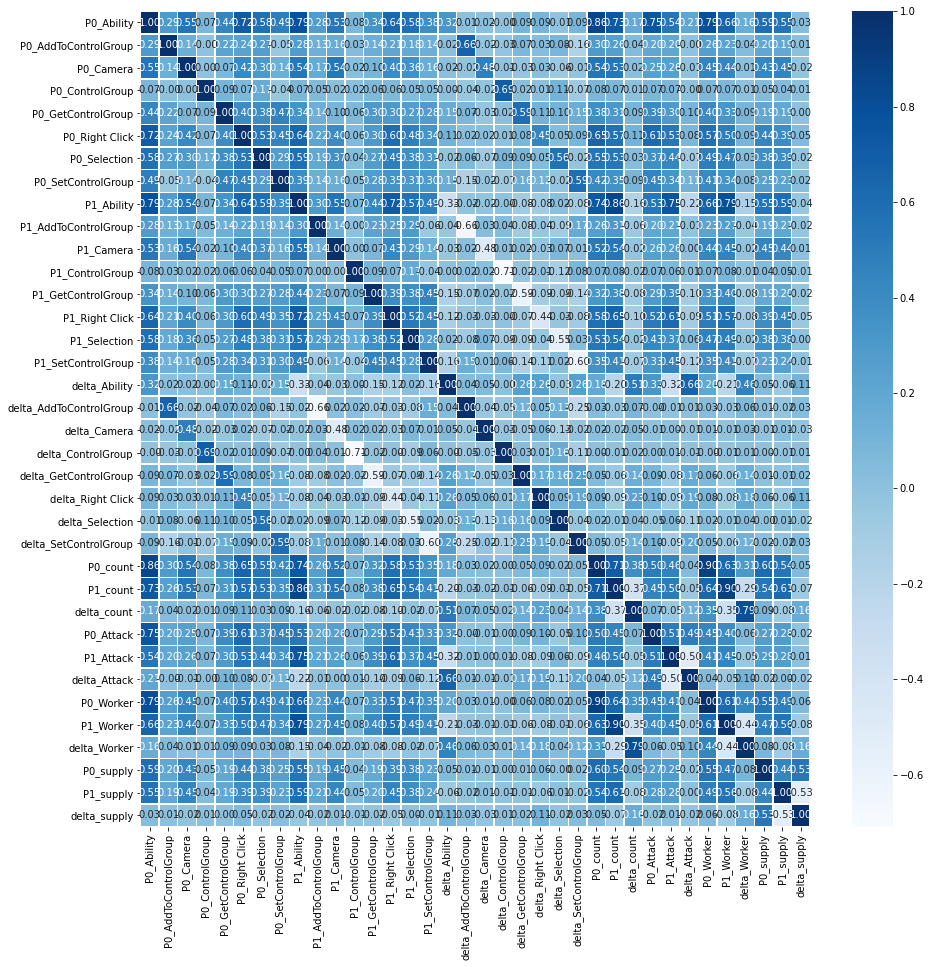

In [128]:
plt.figure(figsize=(15,15))
sns.heatmap(data = x_train.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [19]:
def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha, reg_lambda,max_bin,min_child_samples, max_depth, x_data=None, y_data=None, n_splits=10, output='score'):
    score = 0
    kf = KFold(n_splits=n_splits)
    models = []
    for train_index, valid_index in kf.split(x_data):
        x_train, y_train = x_data.iloc[train_index], y_data[train_index]
        x_valid, y_valid = x_data.iloc[valid_index], y_data[valid_index]
        
        model = lgb.LGBMClassifier(
            num_leaves = int(num_leaves), 
            learning_rate = learning_rate, 
            n_estimators = int(n_estimators), 
            subsample = np.clip(subsample, 0, 1), 
            colsample_bytree = np.clip(colsample_bytree, 0, 1), 
            reg_alpha = reg_alpha, 
            reg_lambda = reg_lambda,
            max_bin = int(max_bin),
            min_child_samples = int(min_child_samples),
            max_depth = int(max_depth),
            boosting = 'dart',
            n_jobs = -1,
        )
        
        model.fit(x_train, y_train)
        models.append(model)
        
        pred = model.predict_proba(x_valid)[:, 1]
        true = y_valid
        score += roc_auc_score(true, pred)/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [22]:
# 모델과 관련없는 변수 고정
func_fixed = partial(lgb_cv, x_data=x_train, y_data=y_train, n_splits=10, output='score') 
# 베이지안 최적화 범위 설정
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (16, 1024),        # num_leaves,       범위(16~1024)
        'learning_rate': (0.0001, 0.1),  # learning_rate,    범위(0.0001~0.1)
        'n_estimators': (100, 2000),      # n_estimators,     범위(16~1024)
        'subsample': (0, 1),             # subsample,        범위(0~1)
        'colsample_bytree': (0.000000000001, 1),      # colsample_bytree, 범위(0~1)
        'reg_alpha': (0, 3),    
        'max_depth' : (0,10),# reg_alpha,        범위(0~10)
        'reg_lambda': (0, 3),
        'max_bin' : (255,300),
        'min_child_samples' : (0, 50),# reg_lambda,       범위(0~50)
    }, 
    random_state=40                    # 시드 고정
)
lgbBO.maximize(init_points=15, n_iter=20)# 처음 5회 랜덤 값으로 score 계산 후 30회 최적화

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.633    |  0.4077   |  0.005631 |  290.5    |  2.873    |  22.52    |  677.4    |  546.6    |  1.871    |  2.33     |  0.6862   |
|  2        |  0.6586   |  0.9809   |  0.06012  |  291.6    |  7.086    |  1.377    |  1.818e+0 |  469.5    |  0.3568   |  2.506    |  0.2022   |
|  3        |  0.6625   |  0.1742   |  0.04497  |  285.1    |  9.574    |  41.67    |  1.066e+0 |  651.1    |  2.505    |  1.342    |  0.7623   |
|  4        |  0.6607   |  0.6369   |  0.03629  |  255.7    |  5.42     |  15.91    |  375.5    |  569.3    |  0.5624   |  1.197    |  0.24     |
|  5        |  0.6394   |  0.03665  |  0.0569   |  296.5    |  1.791    |  35.15    |  1.468e+0 |  47.31    |  1.748    |  2

|  34       |  0.6642   |  0.9789   |  0.02865  |  256.4    |  9.236    |  46.19    |  1.861e+0 |  22.17    |  0.3034   |  0.7245   |  0.1328   |
|  35       |  0.6521   |  0.7051   |  0.04822  |  297.7    |  3.574    |  5.233    |  291.9    |  18.11    |  1.334    |  2.374    |  0.1632   |


In [196]:
params

{'colsample_bytree': 0.3764679628755222,
 'learning_rate': 0.02445374814865627,
 'max_bin': 282.08145510504676,
 'max_depth': 3.296960156864912,
 'min_child_samples': 23.0842588962547,
 'n_estimators': 1477.3406468141056,
 'num_leaves': 834.2774672735567,
 'reg_alpha': 2.958167868994232,
 'reg_lambda': 0.6809662585177101,
 'subsample': 0.5676927779355068}

In [25]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'], 
    params['learning_rate'], 
    params['n_estimators'], 
    params['subsample'], 
    params['colsample_bytree'], 
    params['reg_alpha'], 
    params['reg_lambda'],
    params['max_bin'],
    params['min_child_samples'],
    params['max_depth'],
    x_data=x_train, y_data=y_train, n_splits=10, output='model')

In [34]:
from sklearn.externals import joblib

In [9]:
from sklearn.externals import joblib
load = joblib.load('dart_lightgbm.pkl')

In [17]:
load[0]

LGBMClassifier(boosting='dart', boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.38102558958270594, importance_type='split',
               learning_rate=0.036122707403584565, max_bin=297, max_depth=7,
               min_child_samples=41, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1997, n_jobs=-1, num_leaves=20, objective=None,
               random_state=None, reg_alpha=1.7550594237157937,
               reg_lambda=1.6855992880699224, silent=True,
               subsample=0.2733889824942709, subsample_for_bin=200000,
               subsample_freq=0)

In [11]:
cat_feature = ['P0_species','P1_species','map','player1_starting','player0_starting']

In [14]:
from catboost import CatBoostClassifier

In [15]:
clf = CatBoostClassifier(task_type = 'GPU', learning_rate= 0.01, custom_metric='AUC',cat_features = cat_feature,iterations = 4000)

In [16]:
from sklearn.ensemble import VotingClassifier

In [18]:
vo_clf = VotingClassifier(estimators = [('CLF', clf), ('LGB', load[0])], voting = 'soft')

In [22]:
vo_clf.fit(x_train, y_train)

0:	learn: 0.6926780	total: 87.9ms	remaining: 5m 51s
1:	learn: 0.6921669	total: 173ms	remaining: 5m 45s
2:	learn: 0.6916520	total: 258ms	remaining: 5m 43s
3:	learn: 0.6911605	total: 343ms	remaining: 5m 42s
4:	learn: 0.6907213	total: 424ms	remaining: 5m 38s
5:	learn: 0.6902817	total: 504ms	remaining: 5m 35s
6:	learn: 0.6897722	total: 582ms	remaining: 5m 31s
7:	learn: 0.6893599	total: 662ms	remaining: 5m 30s
8:	learn: 0.6889032	total: 739ms	remaining: 5m 27s
9:	learn: 0.6884996	total: 821ms	remaining: 5m 27s
10:	learn: 0.6880842	total: 903ms	remaining: 5m 27s
11:	learn: 0.6876454	total: 983ms	remaining: 5m 26s
12:	learn: 0.6872333	total: 1.06s	remaining: 5m 25s
13:	learn: 0.6868109	total: 1.14s	remaining: 5m 24s
14:	learn: 0.6864959	total: 1.22s	remaining: 5m 24s
15:	learn: 0.6861142	total: 1.3s	remaining: 5m 23s
16:	learn: 0.6857271	total: 1.38s	remaining: 5m 22s
17:	learn: 0.6852909	total: 1.46s	remaining: 5m 21s
18:	learn: 0.6848503	total: 1.53s	remaining: 5m 21s
19:	learn: 0.6844238	t

159:	learn: 0.6613831	total: 12.8s	remaining: 5m 6s
160:	learn: 0.6613171	total: 12.8s	remaining: 5m 5s
161:	learn: 0.6612330	total: 12.9s	remaining: 5m 5s
162:	learn: 0.6611608	total: 13s	remaining: 5m 5s
163:	learn: 0.6611202	total: 13.1s	remaining: 5m 5s
164:	learn: 0.6610544	total: 13.1s	remaining: 5m 5s
165:	learn: 0.6609669	total: 13.2s	remaining: 5m 5s
166:	learn: 0.6608908	total: 13.3s	remaining: 5m 5s
167:	learn: 0.6608291	total: 13.4s	remaining: 5m 5s
168:	learn: 0.6607557	total: 13.5s	remaining: 5m 5s
169:	learn: 0.6606677	total: 13.5s	remaining: 5m 5s
170:	learn: 0.6605884	total: 13.6s	remaining: 5m 5s
171:	learn: 0.6605343	total: 13.7s	remaining: 5m 4s
172:	learn: 0.6604460	total: 13.8s	remaining: 5m 4s
173:	learn: 0.6603355	total: 13.9s	remaining: 5m 4s
174:	learn: 0.6602892	total: 13.9s	remaining: 5m 4s
175:	learn: 0.6602301	total: 14s	remaining: 5m 4s
176:	learn: 0.6601680	total: 14.1s	remaining: 5m 4s
177:	learn: 0.6601162	total: 14.2s	remaining: 5m 4s
178:	learn: 0.66

318:	learn: 0.6539837	total: 24.9s	remaining: 4m 47s
319:	learn: 0.6539505	total: 25s	remaining: 4m 47s
320:	learn: 0.6539363	total: 25.1s	remaining: 4m 47s
321:	learn: 0.6538806	total: 25.1s	remaining: 4m 47s
322:	learn: 0.6538582	total: 25.2s	remaining: 4m 47s
323:	learn: 0.6538337	total: 25.3s	remaining: 4m 46s
324:	learn: 0.6538078	total: 25.4s	remaining: 4m 46s
325:	learn: 0.6537770	total: 25.4s	remaining: 4m 46s
326:	learn: 0.6537507	total: 25.5s	remaining: 4m 46s
327:	learn: 0.6537133	total: 25.6s	remaining: 4m 46s
328:	learn: 0.6536636	total: 25.7s	remaining: 4m 46s
329:	learn: 0.6536409	total: 25.7s	remaining: 4m 46s
330:	learn: 0.6535941	total: 25.8s	remaining: 4m 46s
331:	learn: 0.6535791	total: 25.9s	remaining: 4m 45s
332:	learn: 0.6535565	total: 26s	remaining: 4m 45s
333:	learn: 0.6535038	total: 26s	remaining: 4m 45s
334:	learn: 0.6534872	total: 26.1s	remaining: 4m 45s
335:	learn: 0.6534349	total: 26.2s	remaining: 4m 45s
336:	learn: 0.6533723	total: 26.3s	remaining: 4m 45s

474:	learn: 0.6505013	total: 36.6s	remaining: 4m 31s
475:	learn: 0.6504741	total: 36.7s	remaining: 4m 31s
476:	learn: 0.6504586	total: 36.8s	remaining: 4m 31s
477:	learn: 0.6504528	total: 36.9s	remaining: 4m 31s
478:	learn: 0.6504200	total: 37s	remaining: 4m 31s
479:	learn: 0.6504007	total: 37s	remaining: 4m 31s
480:	learn: 0.6503914	total: 37.1s	remaining: 4m 31s
481:	learn: 0.6503706	total: 37.2s	remaining: 4m 31s
482:	learn: 0.6503611	total: 37.3s	remaining: 4m 31s
483:	learn: 0.6503332	total: 37.3s	remaining: 4m 31s
484:	learn: 0.6503275	total: 37.4s	remaining: 4m 31s
485:	learn: 0.6502811	total: 37.5s	remaining: 4m 31s
486:	learn: 0.6502507	total: 37.6s	remaining: 4m 30s
487:	learn: 0.6502290	total: 37.6s	remaining: 4m 30s
488:	learn: 0.6502167	total: 37.7s	remaining: 4m 30s
489:	learn: 0.6501930	total: 37.8s	remaining: 4m 30s
490:	learn: 0.6501730	total: 37.9s	remaining: 4m 30s
491:	learn: 0.6501555	total: 37.9s	remaining: 4m 30s
492:	learn: 0.6501378	total: 38s	remaining: 4m 30s

630:	learn: 0.6478909	total: 48.3s	remaining: 4m 17s
631:	learn: 0.6478715	total: 48.4s	remaining: 4m 17s
632:	learn: 0.6478674	total: 48.4s	remaining: 4m 17s
633:	learn: 0.6478538	total: 48.5s	remaining: 4m 17s
634:	learn: 0.6478456	total: 48.6s	remaining: 4m 17s
635:	learn: 0.6478232	total: 48.7s	remaining: 4m 17s
636:	learn: 0.6478104	total: 48.7s	remaining: 4m 17s
637:	learn: 0.6478039	total: 48.8s	remaining: 4m 17s
638:	learn: 0.6477927	total: 48.9s	remaining: 4m 17s
639:	learn: 0.6477718	total: 49s	remaining: 4m 17s
640:	learn: 0.6477610	total: 49s	remaining: 4m 16s
641:	learn: 0.6477529	total: 49.1s	remaining: 4m 16s
642:	learn: 0.6477494	total: 49.2s	remaining: 4m 16s
643:	learn: 0.6477415	total: 49.3s	remaining: 4m 16s
644:	learn: 0.6477317	total: 49.3s	remaining: 4m 16s
645:	learn: 0.6477213	total: 49.4s	remaining: 4m 16s
646:	learn: 0.6477124	total: 49.5s	remaining: 4m 16s
647:	learn: 0.6476930	total: 49.6s	remaining: 4m 16s
648:	learn: 0.6476813	total: 49.6s	remaining: 4m 1

787:	learn: 0.6457472	total: 60s	remaining: 4m 4s
788:	learn: 0.6457291	total: 1m	remaining: 4m 4s
789:	learn: 0.6457215	total: 1m	remaining: 4m 4s
790:	learn: 0.6457105	total: 1m	remaining: 4m 4s
791:	learn: 0.6456920	total: 1m	remaining: 4m 4s
792:	learn: 0.6456914	total: 1m	remaining: 4m 4s
793:	learn: 0.6456830	total: 1m	remaining: 4m 3s
794:	learn: 0.6456737	total: 1m	remaining: 4m 3s
795:	learn: 0.6456676	total: 1m	remaining: 4m 3s
796:	learn: 0.6456585	total: 1m	remaining: 4m 3s
797:	learn: 0.6456430	total: 1m	remaining: 4m 3s
798:	learn: 0.6456395	total: 1m	remaining: 4m 3s
799:	learn: 0.6456235	total: 1m	remaining: 4m 3s
800:	learn: 0.6455856	total: 1m	remaining: 4m 3s
801:	learn: 0.6455734	total: 1m 1s	remaining: 4m 3s
802:	learn: 0.6455729	total: 1m 1s	remaining: 4m 3s
803:	learn: 0.6455622	total: 1m 1s	remaining: 4m 3s
804:	learn: 0.6455498	total: 1m 1s	remaining: 4m 3s
805:	learn: 0.6455406	total: 1m 1s	remaining: 4m 2s
806:	learn: 0.6455261	total: 1m 1s	remaining: 4m 2s
8

944:	learn: 0.6439513	total: 1m 11s	remaining: 3m 51s
945:	learn: 0.6439430	total: 1m 11s	remaining: 3m 51s
946:	learn: 0.6439266	total: 1m 11s	remaining: 3m 51s
947:	learn: 0.6439130	total: 1m 11s	remaining: 3m 51s
948:	learn: 0.6439126	total: 1m 11s	remaining: 3m 51s
949:	learn: 0.6439052	total: 1m 11s	remaining: 3m 51s
950:	learn: 0.6438930	total: 1m 12s	remaining: 3m 51s
951:	learn: 0.6438829	total: 1m 12s	remaining: 3m 50s
952:	learn: 0.6438723	total: 1m 12s	remaining: 3m 50s
953:	learn: 0.6438570	total: 1m 12s	remaining: 3m 50s
954:	learn: 0.6438472	total: 1m 12s	remaining: 3m 50s
955:	learn: 0.6438450	total: 1m 12s	remaining: 3m 50s
956:	learn: 0.6438392	total: 1m 12s	remaining: 3m 50s
957:	learn: 0.6438122	total: 1m 12s	remaining: 3m 50s
958:	learn: 0.6437960	total: 1m 12s	remaining: 3m 50s
959:	learn: 0.6437855	total: 1m 12s	remaining: 3m 50s
960:	learn: 0.6437631	total: 1m 12s	remaining: 3m 50s
961:	learn: 0.6437485	total: 1m 12s	remaining: 3m 50s
962:	learn: 0.6437383	total:

1095:	learn: 0.6421401	total: 1m 23s	remaining: 3m 40s
1096:	learn: 0.6421360	total: 1m 23s	remaining: 3m 40s
1097:	learn: 0.6421357	total: 1m 23s	remaining: 3m 40s
1098:	learn: 0.6421225	total: 1m 23s	remaining: 3m 39s
1099:	learn: 0.6421121	total: 1m 23s	remaining: 3m 39s
1100:	learn: 0.6421015	total: 1m 23s	remaining: 3m 39s
1101:	learn: 0.6420760	total: 1m 23s	remaining: 3m 39s
1102:	learn: 0.6420754	total: 1m 23s	remaining: 3m 39s
1103:	learn: 0.6420643	total: 1m 23s	remaining: 3m 39s
1104:	learn: 0.6420475	total: 1m 23s	remaining: 3m 39s
1105:	learn: 0.6420252	total: 1m 23s	remaining: 3m 39s
1106:	learn: 0.6420146	total: 1m 23s	remaining: 3m 39s
1107:	learn: 0.6419932	total: 1m 24s	remaining: 3m 39s
1108:	learn: 0.6419919	total: 1m 24s	remaining: 3m 39s
1109:	learn: 0.6419728	total: 1m 24s	remaining: 3m 39s
1110:	learn: 0.6419590	total: 1m 24s	remaining: 3m 39s
1111:	learn: 0.6419432	total: 1m 24s	remaining: 3m 38s
1112:	learn: 0.6419294	total: 1m 24s	remaining: 3m 38s
1113:	lear

1246:	learn: 0.6402987	total: 1m 34s	remaining: 3m 28s
1247:	learn: 0.6402985	total: 1m 34s	remaining: 3m 28s
1248:	learn: 0.6402976	total: 1m 34s	remaining: 3m 27s
1249:	learn: 0.6402693	total: 1m 34s	remaining: 3m 27s
1250:	learn: 0.6402400	total: 1m 34s	remaining: 3m 27s
1251:	learn: 0.6402397	total: 1m 34s	remaining: 3m 27s
1252:	learn: 0.6402391	total: 1m 34s	remaining: 3m 27s
1253:	learn: 0.6402361	total: 1m 34s	remaining: 3m 27s
1254:	learn: 0.6402356	total: 1m 34s	remaining: 3m 27s
1255:	learn: 0.6402161	total: 1m 34s	remaining: 3m 27s
1256:	learn: 0.6402157	total: 1m 34s	remaining: 3m 27s
1257:	learn: 0.6402100	total: 1m 35s	remaining: 3m 27s
1258:	learn: 0.6402092	total: 1m 35s	remaining: 3m 27s
1259:	learn: 0.6402079	total: 1m 35s	remaining: 3m 27s
1260:	learn: 0.6402073	total: 1m 35s	remaining: 3m 26s
1261:	learn: 0.6402067	total: 1m 35s	remaining: 3m 26s
1262:	learn: 0.6402062	total: 1m 35s	remaining: 3m 26s
1263:	learn: 0.6401892	total: 1m 35s	remaining: 3m 26s
1264:	lear

1397:	learn: 0.6388329	total: 1m 45s	remaining: 3m 15s
1398:	learn: 0.6388325	total: 1m 45s	remaining: 3m 15s
1399:	learn: 0.6388256	total: 1m 45s	remaining: 3m 15s
1400:	learn: 0.6388118	total: 1m 45s	remaining: 3m 15s
1401:	learn: 0.6387914	total: 1m 45s	remaining: 3m 15s
1402:	learn: 0.6387736	total: 1m 45s	remaining: 3m 15s
1403:	learn: 0.6387724	total: 1m 45s	remaining: 3m 15s
1404:	learn: 0.6387718	total: 1m 45s	remaining: 3m 15s
1405:	learn: 0.6387714	total: 1m 45s	remaining: 3m 15s
1406:	learn: 0.6387711	total: 1m 45s	remaining: 3m 15s
1407:	learn: 0.6387695	total: 1m 46s	remaining: 3m 15s
1408:	learn: 0.6387690	total: 1m 46s	remaining: 3m 15s
1409:	learn: 0.6387685	total: 1m 46s	remaining: 3m 15s
1410:	learn: 0.6387683	total: 1m 46s	remaining: 3m 14s
1411:	learn: 0.6387482	total: 1m 46s	remaining: 3m 14s
1412:	learn: 0.6387479	total: 1m 46s	remaining: 3m 14s
1413:	learn: 0.6387381	total: 1m 46s	remaining: 3m 14s
1414:	learn: 0.6387213	total: 1m 46s	remaining: 3m 14s
1415:	lear

1548:	learn: 0.6375129	total: 1m 56s	remaining: 3m 3s
1549:	learn: 0.6374972	total: 1m 56s	remaining: 3m 3s
1550:	learn: 0.6374729	total: 1m 56s	remaining: 3m 3s
1551:	learn: 0.6374381	total: 1m 56s	remaining: 3m 3s
1552:	learn: 0.6374279	total: 1m 56s	remaining: 3m 3s
1553:	learn: 0.6374215	total: 1m 56s	remaining: 3m 3s
1554:	learn: 0.6373879	total: 1m 56s	remaining: 3m 3s
1555:	learn: 0.6373697	total: 1m 56s	remaining: 3m 3s
1556:	learn: 0.6373575	total: 1m 56s	remaining: 3m 3s
1557:	learn: 0.6373570	total: 1m 56s	remaining: 3m 3s
1558:	learn: 0.6373569	total: 1m 57s	remaining: 3m 3s
1559:	learn: 0.6373567	total: 1m 57s	remaining: 3m 3s
1560:	learn: 0.6373502	total: 1m 57s	remaining: 3m 3s
1561:	learn: 0.6373280	total: 1m 57s	remaining: 3m 2s
1562:	learn: 0.6372975	total: 1m 57s	remaining: 3m 2s
1563:	learn: 0.6372970	total: 1m 57s	remaining: 3m 2s
1564:	learn: 0.6372969	total: 1m 57s	remaining: 3m 2s
1565:	learn: 0.6372968	total: 1m 57s	remaining: 3m 2s
1566:	learn: 0.6372968	total

1703:	learn: 0.6360891	total: 2m 7s	remaining: 2m 52s
1704:	learn: 0.6360878	total: 2m 7s	remaining: 2m 51s
1705:	learn: 0.6360840	total: 2m 7s	remaining: 2m 51s
1706:	learn: 0.6360705	total: 2m 7s	remaining: 2m 51s
1707:	learn: 0.6360572	total: 2m 7s	remaining: 2m 51s
1708:	learn: 0.6360566	total: 2m 8s	remaining: 2m 51s
1709:	learn: 0.6360560	total: 2m 8s	remaining: 2m 51s
1710:	learn: 0.6360261	total: 2m 8s	remaining: 2m 51s
1711:	learn: 0.6360153	total: 2m 8s	remaining: 2m 51s
1712:	learn: 0.6359864	total: 2m 8s	remaining: 2m 51s
1713:	learn: 0.6359821	total: 2m 8s	remaining: 2m 51s
1714:	learn: 0.6359820	total: 2m 8s	remaining: 2m 51s
1715:	learn: 0.6359818	total: 2m 8s	remaining: 2m 51s
1716:	learn: 0.6359807	total: 2m 8s	remaining: 2m 50s
1717:	learn: 0.6359654	total: 2m 8s	remaining: 2m 50s
1718:	learn: 0.6359605	total: 2m 8s	remaining: 2m 50s
1719:	learn: 0.6359536	total: 2m 8s	remaining: 2m 50s
1720:	learn: 0.6359360	total: 2m 8s	remaining: 2m 50s
1721:	learn: 0.6359348	total

1853:	learn: 0.6348074	total: 2m 18s	remaining: 2m 40s
1854:	learn: 0.6347933	total: 2m 18s	remaining: 2m 40s
1855:	learn: 0.6347890	total: 2m 18s	remaining: 2m 40s
1856:	learn: 0.6347819	total: 2m 18s	remaining: 2m 40s
1857:	learn: 0.6347755	total: 2m 18s	remaining: 2m 40s
1858:	learn: 0.6347591	total: 2m 18s	remaining: 2m 39s
1859:	learn: 0.6347514	total: 2m 18s	remaining: 2m 39s
1860:	learn: 0.6347292	total: 2m 19s	remaining: 2m 39s
1861:	learn: 0.6347060	total: 2m 19s	remaining: 2m 39s
1862:	learn: 0.6346875	total: 2m 19s	remaining: 2m 39s
1863:	learn: 0.6346668	total: 2m 19s	remaining: 2m 39s
1864:	learn: 0.6346666	total: 2m 19s	remaining: 2m 39s
1865:	learn: 0.6346607	total: 2m 19s	remaining: 2m 39s
1866:	learn: 0.6346606	total: 2m 19s	remaining: 2m 39s
1867:	learn: 0.6346603	total: 2m 19s	remaining: 2m 39s
1868:	learn: 0.6346601	total: 2m 19s	remaining: 2m 39s
1869:	learn: 0.6346597	total: 2m 19s	remaining: 2m 39s
1870:	learn: 0.6346594	total: 2m 19s	remaining: 2m 39s
1871:	lear

2003:	learn: 0.6336000	total: 2m 29s	remaining: 2m 28s
2004:	learn: 0.6335995	total: 2m 29s	remaining: 2m 28s
2005:	learn: 0.6335994	total: 2m 29s	remaining: 2m 28s
2006:	learn: 0.6335935	total: 2m 29s	remaining: 2m 28s
2007:	learn: 0.6335833	total: 2m 29s	remaining: 2m 28s
2008:	learn: 0.6335830	total: 2m 29s	remaining: 2m 28s
2009:	learn: 0.6335828	total: 2m 29s	remaining: 2m 28s
2010:	learn: 0.6335824	total: 2m 30s	remaining: 2m 28s
2011:	learn: 0.6335802	total: 2m 30s	remaining: 2m 28s
2012:	learn: 0.6335772	total: 2m 30s	remaining: 2m 28s
2013:	learn: 0.6335765	total: 2m 30s	remaining: 2m 28s
2014:	learn: 0.6335733	total: 2m 30s	remaining: 2m 28s
2015:	learn: 0.6335621	total: 2m 30s	remaining: 2m 28s
2016:	learn: 0.6335617	total: 2m 30s	remaining: 2m 27s
2017:	learn: 0.6335469	total: 2m 30s	remaining: 2m 27s
2018:	learn: 0.6335293	total: 2m 30s	remaining: 2m 27s
2019:	learn: 0.6335131	total: 2m 30s	remaining: 2m 27s
2020:	learn: 0.6335096	total: 2m 30s	remaining: 2m 27s
2021:	lear

2153:	learn: 0.6321610	total: 2m 40s	remaining: 2m 17s
2154:	learn: 0.6321566	total: 2m 40s	remaining: 2m 17s
2155:	learn: 0.6321501	total: 2m 40s	remaining: 2m 17s
2156:	learn: 0.6321430	total: 2m 40s	remaining: 2m 17s
2157:	learn: 0.6321401	total: 2m 40s	remaining: 2m 17s
2158:	learn: 0.6321329	total: 2m 41s	remaining: 2m 17s
2159:	learn: 0.6321211	total: 2m 41s	remaining: 2m 17s
2160:	learn: 0.6321021	total: 2m 41s	remaining: 2m 17s
2161:	learn: 0.6320867	total: 2m 41s	remaining: 2m 17s
2162:	learn: 0.6320865	total: 2m 41s	remaining: 2m 17s
2163:	learn: 0.6320628	total: 2m 41s	remaining: 2m 16s
2164:	learn: 0.6320623	total: 2m 41s	remaining: 2m 16s
2165:	learn: 0.6320459	total: 2m 41s	remaining: 2m 16s
2166:	learn: 0.6320452	total: 2m 41s	remaining: 2m 16s
2167:	learn: 0.6320262	total: 2m 41s	remaining: 2m 16s
2168:	learn: 0.6320177	total: 2m 41s	remaining: 2m 16s
2169:	learn: 0.6320168	total: 2m 41s	remaining: 2m 16s
2170:	learn: 0.6319986	total: 2m 41s	remaining: 2m 16s
2171:	lear

2303:	learn: 0.6309192	total: 2m 51s	remaining: 2m 6s
2304:	learn: 0.6309188	total: 2m 51s	remaining: 2m 6s
2305:	learn: 0.6309096	total: 2m 51s	remaining: 2m 6s
2306:	learn: 0.6309039	total: 2m 52s	remaining: 2m 6s
2307:	learn: 0.6309037	total: 2m 52s	remaining: 2m 6s
2308:	learn: 0.6309033	total: 2m 52s	remaining: 2m 6s
2309:	learn: 0.6309028	total: 2m 52s	remaining: 2m 6s
2310:	learn: 0.6308938	total: 2m 52s	remaining: 2m 5s
2311:	learn: 0.6308936	total: 2m 52s	remaining: 2m 5s
2312:	learn: 0.6308871	total: 2m 52s	remaining: 2m 5s
2313:	learn: 0.6308851	total: 2m 52s	remaining: 2m 5s
2314:	learn: 0.6308681	total: 2m 52s	remaining: 2m 5s
2315:	learn: 0.6308536	total: 2m 52s	remaining: 2m 5s
2316:	learn: 0.6308532	total: 2m 52s	remaining: 2m 5s
2317:	learn: 0.6308456	total: 2m 52s	remaining: 2m 5s
2318:	learn: 0.6308388	total: 2m 52s	remaining: 2m 5s
2319:	learn: 0.6308167	total: 2m 53s	remaining: 2m 5s
2320:	learn: 0.6308088	total: 2m 53s	remaining: 2m 5s
2321:	learn: 0.6307987	total

2456:	learn: 0.6296633	total: 3m 3s	remaining: 1m 55s
2457:	learn: 0.6296523	total: 3m 3s	remaining: 1m 55s
2458:	learn: 0.6296521	total: 3m 3s	remaining: 1m 54s
2459:	learn: 0.6296515	total: 3m 3s	remaining: 1m 54s
2460:	learn: 0.6296513	total: 3m 3s	remaining: 1m 54s
2461:	learn: 0.6296444	total: 3m 3s	remaining: 1m 54s
2462:	learn: 0.6296442	total: 3m 3s	remaining: 1m 54s
2463:	learn: 0.6296424	total: 3m 3s	remaining: 1m 54s
2464:	learn: 0.6296363	total: 3m 3s	remaining: 1m 54s
2465:	learn: 0.6296179	total: 3m 3s	remaining: 1m 54s
2466:	learn: 0.6296003	total: 3m 4s	remaining: 1m 54s
2467:	learn: 0.6295965	total: 3m 4s	remaining: 1m 54s
2468:	learn: 0.6295943	total: 3m 4s	remaining: 1m 54s
2469:	learn: 0.6295919	total: 3m 4s	remaining: 1m 54s
2470:	learn: 0.6295735	total: 3m 4s	remaining: 1m 54s
2471:	learn: 0.6295632	total: 3m 4s	remaining: 1m 53s
2472:	learn: 0.6295506	total: 3m 4s	remaining: 1m 53s
2473:	learn: 0.6295464	total: 3m 4s	remaining: 1m 53s
2474:	learn: 0.6295382	total

2609:	learn: 0.6284374	total: 3m 14s	remaining: 1m 43s
2610:	learn: 0.6284371	total: 3m 14s	remaining: 1m 43s
2611:	learn: 0.6284219	total: 3m 14s	remaining: 1m 43s
2612:	learn: 0.6284216	total: 3m 14s	remaining: 1m 43s
2613:	learn: 0.6284074	total: 3m 14s	remaining: 1m 43s
2614:	learn: 0.6283954	total: 3m 15s	remaining: 1m 43s
2615:	learn: 0.6283952	total: 3m 15s	remaining: 1m 43s
2616:	learn: 0.6283876	total: 3m 15s	remaining: 1m 43s
2617:	learn: 0.6283707	total: 3m 15s	remaining: 1m 43s
2618:	learn: 0.6283705	total: 3m 15s	remaining: 1m 43s
2619:	learn: 0.6283567	total: 3m 15s	remaining: 1m 42s
2620:	learn: 0.6283564	total: 3m 15s	remaining: 1m 42s
2621:	learn: 0.6283557	total: 3m 15s	remaining: 1m 42s
2622:	learn: 0.6283372	total: 3m 15s	remaining: 1m 42s
2623:	learn: 0.6283346	total: 3m 15s	remaining: 1m 42s
2624:	learn: 0.6283343	total: 3m 15s	remaining: 1m 42s
2625:	learn: 0.6283186	total: 3m 15s	remaining: 1m 42s
2626:	learn: 0.6283114	total: 3m 15s	remaining: 1m 42s
2627:	lear

2759:	learn: 0.6272664	total: 3m 25s	remaining: 1m 32s
2760:	learn: 0.6272458	total: 3m 25s	remaining: 1m 32s
2761:	learn: 0.6272379	total: 3m 25s	remaining: 1m 32s
2762:	learn: 0.6272375	total: 3m 25s	remaining: 1m 32s
2763:	learn: 0.6272303	total: 3m 26s	remaining: 1m 32s
2764:	learn: 0.6272060	total: 3m 26s	remaining: 1m 32s
2765:	learn: 0.6272039	total: 3m 26s	remaining: 1m 31s
2766:	learn: 0.6271850	total: 3m 26s	remaining: 1m 31s
2767:	learn: 0.6271566	total: 3m 26s	remaining: 1m 31s
2768:	learn: 0.6271473	total: 3m 26s	remaining: 1m 31s
2769:	learn: 0.6271432	total: 3m 26s	remaining: 1m 31s
2770:	learn: 0.6271429	total: 3m 26s	remaining: 1m 31s
2771:	learn: 0.6271379	total: 3m 26s	remaining: 1m 31s
2772:	learn: 0.6271377	total: 3m 26s	remaining: 1m 31s
2773:	learn: 0.6271306	total: 3m 26s	remaining: 1m 31s
2774:	learn: 0.6271293	total: 3m 26s	remaining: 1m 31s
2775:	learn: 0.6271271	total: 3m 26s	remaining: 1m 31s
2776:	learn: 0.6271268	total: 3m 26s	remaining: 1m 31s
2777:	lear

2909:	learn: 0.6262504	total: 3m 36s	remaining: 1m 21s
2910:	learn: 0.6262502	total: 3m 37s	remaining: 1m 21s
2911:	learn: 0.6262442	total: 3m 37s	remaining: 1m 21s
2912:	learn: 0.6262441	total: 3m 37s	remaining: 1m 21s
2913:	learn: 0.6262441	total: 3m 37s	remaining: 1m 20s
2914:	learn: 0.6262259	total: 3m 37s	remaining: 1m 20s
2915:	learn: 0.6262149	total: 3m 37s	remaining: 1m 20s
2916:	learn: 0.6262148	total: 3m 37s	remaining: 1m 20s
2917:	learn: 0.6261976	total: 3m 37s	remaining: 1m 20s
2918:	learn: 0.6261975	total: 3m 37s	remaining: 1m 20s
2919:	learn: 0.6261872	total: 3m 37s	remaining: 1m 20s
2920:	learn: 0.6261870	total: 3m 37s	remaining: 1m 20s
2921:	learn: 0.6261809	total: 3m 37s	remaining: 1m 20s
2922:	learn: 0.6261797	total: 3m 37s	remaining: 1m 20s
2923:	learn: 0.6261797	total: 3m 38s	remaining: 1m 20s
2924:	learn: 0.6261795	total: 3m 38s	remaining: 1m 20s
2925:	learn: 0.6261794	total: 3m 38s	remaining: 1m 20s
2926:	learn: 0.6261623	total: 3m 38s	remaining: 1m 20s
2927:	lear

3059:	learn: 0.6253468	total: 3m 48s	remaining: 1m 10s
3060:	learn: 0.6253347	total: 3m 48s	remaining: 1m 10s
3061:	learn: 0.6253346	total: 3m 48s	remaining: 1m 9s
3062:	learn: 0.6253124	total: 3m 48s	remaining: 1m 9s
3063:	learn: 0.6253083	total: 3m 48s	remaining: 1m 9s
3064:	learn: 0.6253048	total: 3m 48s	remaining: 1m 9s
3065:	learn: 0.6252921	total: 3m 48s	remaining: 1m 9s
3066:	learn: 0.6252921	total: 3m 48s	remaining: 1m 9s
3067:	learn: 0.6252810	total: 3m 48s	remaining: 1m 9s
3068:	learn: 0.6252792	total: 3m 48s	remaining: 1m 9s
3069:	learn: 0.6252793	total: 3m 49s	remaining: 1m 9s
3070:	learn: 0.6252721	total: 3m 49s	remaining: 1m 9s
3071:	learn: 0.6252719	total: 3m 49s	remaining: 1m 9s
3072:	learn: 0.6252718	total: 3m 49s	remaining: 1m 9s
3073:	learn: 0.6252717	total: 3m 49s	remaining: 1m 9s
3074:	learn: 0.6252716	total: 3m 49s	remaining: 1m 8s
3075:	learn: 0.6252714	total: 3m 49s	remaining: 1m 8s
3076:	learn: 0.6252713	total: 3m 49s	remaining: 1m 8s
3077:	learn: 0.6252712	tot

3212:	learn: 0.6246811	total: 3m 59s	remaining: 58.6s
3213:	learn: 0.6246808	total: 3m 59s	remaining: 58.6s
3214:	learn: 0.6246807	total: 3m 59s	remaining: 58.5s
3215:	learn: 0.6246805	total: 3m 59s	remaining: 58.4s
3216:	learn: 0.6246583	total: 3m 59s	remaining: 58.3s
3217:	learn: 0.6246388	total: 3m 59s	remaining: 58.3s
3218:	learn: 0.6246271	total: 3m 59s	remaining: 58.2s
3219:	learn: 0.6246269	total: 3m 59s	remaining: 58.1s
3220:	learn: 0.6246265	total: 3m 59s	remaining: 58s
3221:	learn: 0.6246264	total: 4m	remaining: 58s
3222:	learn: 0.6246200	total: 4m	remaining: 57.9s
3223:	learn: 0.6246198	total: 4m	remaining: 57.8s
3224:	learn: 0.6245914	total: 4m	remaining: 57.7s
3225:	learn: 0.6245913	total: 4m	remaining: 57.7s
3226:	learn: 0.6245841	total: 4m	remaining: 57.6s
3227:	learn: 0.6245757	total: 4m	remaining: 57.5s
3228:	learn: 0.6245756	total: 4m	remaining: 57.4s
3229:	learn: 0.6245754	total: 4m	remaining: 57.4s
3230:	learn: 0.6245753	total: 4m	remaining: 57.3s
3231:	learn: 0.624

3369:	learn: 0.6237726	total: 4m 10s	remaining: 46.9s
3370:	learn: 0.6237724	total: 4m 10s	remaining: 46.8s
3371:	learn: 0.6237722	total: 4m 11s	remaining: 46.8s
3372:	learn: 0.6237722	total: 4m 11s	remaining: 46.7s
3373:	learn: 0.6237695	total: 4m 11s	remaining: 46.6s
3374:	learn: 0.6237693	total: 4m 11s	remaining: 46.5s
3375:	learn: 0.6237647	total: 4m 11s	remaining: 46.5s
3376:	learn: 0.6237524	total: 4m 11s	remaining: 46.4s
3377:	learn: 0.6237522	total: 4m 11s	remaining: 46.3s
3378:	learn: 0.6237520	total: 4m 11s	remaining: 46.2s
3379:	learn: 0.6237518	total: 4m 11s	remaining: 46.2s
3380:	learn: 0.6237519	total: 4m 11s	remaining: 46.1s
3381:	learn: 0.6237517	total: 4m 11s	remaining: 46s
3382:	learn: 0.6237425	total: 4m 11s	remaining: 45.9s
3383:	learn: 0.6237424	total: 4m 11s	remaining: 45.9s
3384:	learn: 0.6237338	total: 4m 12s	remaining: 45.8s
3385:	learn: 0.6237282	total: 4m 12s	remaining: 45.7s
3386:	learn: 0.6237281	total: 4m 12s	remaining: 45.6s
3387:	learn: 0.6237280	total: 

3523:	learn: 0.6232682	total: 4m 22s	remaining: 35.4s
3524:	learn: 0.6232681	total: 4m 22s	remaining: 35.3s
3525:	learn: 0.6232679	total: 4m 22s	remaining: 35.3s
3526:	learn: 0.6232678	total: 4m 22s	remaining: 35.2s
3527:	learn: 0.6232672	total: 4m 22s	remaining: 35.1s
3528:	learn: 0.6232671	total: 4m 22s	remaining: 35s
3529:	learn: 0.6232670	total: 4m 22s	remaining: 35s
3530:	learn: 0.6232663	total: 4m 22s	remaining: 34.9s
3531:	learn: 0.6232597	total: 4m 22s	remaining: 34.8s
3532:	learn: 0.6232597	total: 4m 22s	remaining: 34.7s
3533:	learn: 0.6232334	total: 4m 22s	remaining: 34.7s
3534:	learn: 0.6232261	total: 4m 22s	remaining: 34.6s
3535:	learn: 0.6232195	total: 4m 22s	remaining: 34.5s
3536:	learn: 0.6232190	total: 4m 23s	remaining: 34.4s
3537:	learn: 0.6231985	total: 4m 23s	remaining: 34.4s
3538:	learn: 0.6231857	total: 4m 23s	remaining: 34.3s
3539:	learn: 0.6231844	total: 4m 23s	remaining: 34.2s
3540:	learn: 0.6231843	total: 4m 23s	remaining: 34.1s
3541:	learn: 0.6231842	total: 4m

3678:	learn: 0.6225748	total: 4m 33s	remaining: 23.9s
3679:	learn: 0.6225747	total: 4m 33s	remaining: 23.8s
3680:	learn: 0.6225746	total: 4m 33s	remaining: 23.7s
3681:	learn: 0.6225724	total: 4m 33s	remaining: 23.6s
3682:	learn: 0.6225724	total: 4m 33s	remaining: 23.6s
3683:	learn: 0.6225684	total: 4m 33s	remaining: 23.5s
3684:	learn: 0.6225684	total: 4m 33s	remaining: 23.4s
3685:	learn: 0.6225621	total: 4m 33s	remaining: 23.3s
3686:	learn: 0.6225620	total: 4m 33s	remaining: 23.3s
3687:	learn: 0.6225499	total: 4m 33s	remaining: 23.2s
3688:	learn: 0.6225414	total: 4m 34s	remaining: 23.1s
3689:	learn: 0.6225413	total: 4m 34s	remaining: 23s
3690:	learn: 0.6225236	total: 4m 34s	remaining: 23s
3691:	learn: 0.6225235	total: 4m 34s	remaining: 22.9s
3692:	learn: 0.6225235	total: 4m 34s	remaining: 22.8s
3693:	learn: 0.6225151	total: 4m 34s	remaining: 22.7s
3694:	learn: 0.6225152	total: 4m 34s	remaining: 22.7s
3695:	learn: 0.6225150	total: 4m 34s	remaining: 22.6s
3696:	learn: 0.6225058	total: 4m

3832:	learn: 0.6220100	total: 4m 44s	remaining: 12.4s
3833:	learn: 0.6220021	total: 4m 44s	remaining: 12.3s
3834:	learn: 0.6220020	total: 4m 44s	remaining: 12.2s
3835:	learn: 0.6220020	total: 4m 44s	remaining: 12.2s
3836:	learn: 0.6220020	total: 4m 44s	remaining: 12.1s
3837:	learn: 0.6220020	total: 4m 44s	remaining: 12s
3838:	learn: 0.6220018	total: 4m 44s	remaining: 11.9s
3839:	learn: 0.6220018	total: 4m 44s	remaining: 11.9s
3840:	learn: 0.6219962	total: 4m 45s	remaining: 11.8s
3841:	learn: 0.6219862	total: 4m 45s	remaining: 11.7s
3842:	learn: 0.6219862	total: 4m 45s	remaining: 11.7s
3843:	learn: 0.6219740	total: 4m 45s	remaining: 11.6s
3844:	learn: 0.6219718	total: 4m 45s	remaining: 11.5s
3845:	learn: 0.6219718	total: 4m 45s	remaining: 11.4s
3846:	learn: 0.6219672	total: 4m 45s	remaining: 11.4s
3847:	learn: 0.6219671	total: 4m 45s	remaining: 11.3s
3848:	learn: 0.6219672	total: 4m 45s	remaining: 11.2s
3849:	learn: 0.6219644	total: 4m 45s	remaining: 11.1s
3850:	learn: 0.6219644	total: 

3986:	learn: 0.6213874	total: 4m 55s	remaining: 964ms
3987:	learn: 0.6213827	total: 4m 55s	remaining: 890ms
3988:	learn: 0.6213826	total: 4m 55s	remaining: 816ms
3989:	learn: 0.6213825	total: 4m 55s	remaining: 742ms
3990:	learn: 0.6213805	total: 4m 55s	remaining: 667ms
3991:	learn: 0.6213683	total: 4m 56s	remaining: 593ms
3992:	learn: 0.6213682	total: 4m 56s	remaining: 519ms
3993:	learn: 0.6213682	total: 4m 56s	remaining: 445ms
3994:	learn: 0.6213567	total: 4m 56s	remaining: 371ms
3995:	learn: 0.6213397	total: 4m 56s	remaining: 297ms
3996:	learn: 0.6213396	total: 4m 56s	remaining: 222ms
3997:	learn: 0.6213396	total: 4m 56s	remaining: 148ms
3998:	learn: 0.6213395	total: 4m 56s	remaining: 74.2ms
3999:	learn: 0.6213394	total: 4m 56s	remaining: 0us


VotingClassifier(estimators=[('CLF',
                              <catboost.core.CatBoostClassifier object at 0x7f7380fca8d0>),
                             ('LGB',
                              LGBMClassifier(boosting='dart',
                                             boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=0.38102558958270594,
                                             importance_type='split',
                                             learning_rate=0.036122707403584565,
                                             max_bin=297, max_depth=7,
                                             min_child_samples=41,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=1997, n_jobs=-1,
                                             num_leaves=20, 

In [30]:
pred = vo_clf.predict_proba(x_test)

array([[0.37435336, 0.62564664],
       [0.5711053 , 0.4288947 ],
       [0.40757074, 0.59242926],
       ...,
       [0.3238697 , 0.6761303 ],
       [0.39706469, 0.60293531],
       [0.43176175, 0.56823825]])

In [35]:
joblib.dump(models, 'dart_lightgbm.pkl')

['dart_lightgbm.pkl']

In [36]:
load = joblib.load('dart_lightgbm.pkl')

In [37]:
load

[LGBMClassifier(boosting='dart', boosting_type='gbdt', class_weight=None,
                colsample_bytree=0.38102558958270594, importance_type='split',
                learning_rate=0.036122707403584565, max_bin=297, max_depth=7,
                min_child_samples=41, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=1997, n_jobs=-1, num_leaves=20, objective=None,
                random_state=None, reg_alpha=1.7550594237157937,
                reg_lambda=1.6855992880699224, silent=True,
                subsample=0.2733889824942709, subsample_for_bin=200000,
                subsample_freq=0),
 LGBMClassifier(boosting='dart', boosting_type='gbdt', class_weight=None,
                colsample_bytree=0.38102558958270594, importance_type='split',
                learning_rate=0.036122707403584565, max_bin=297, max_depth=7,
                min_child_samples=41, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=1997, n_jobs=-1, num_leaves=20, obje

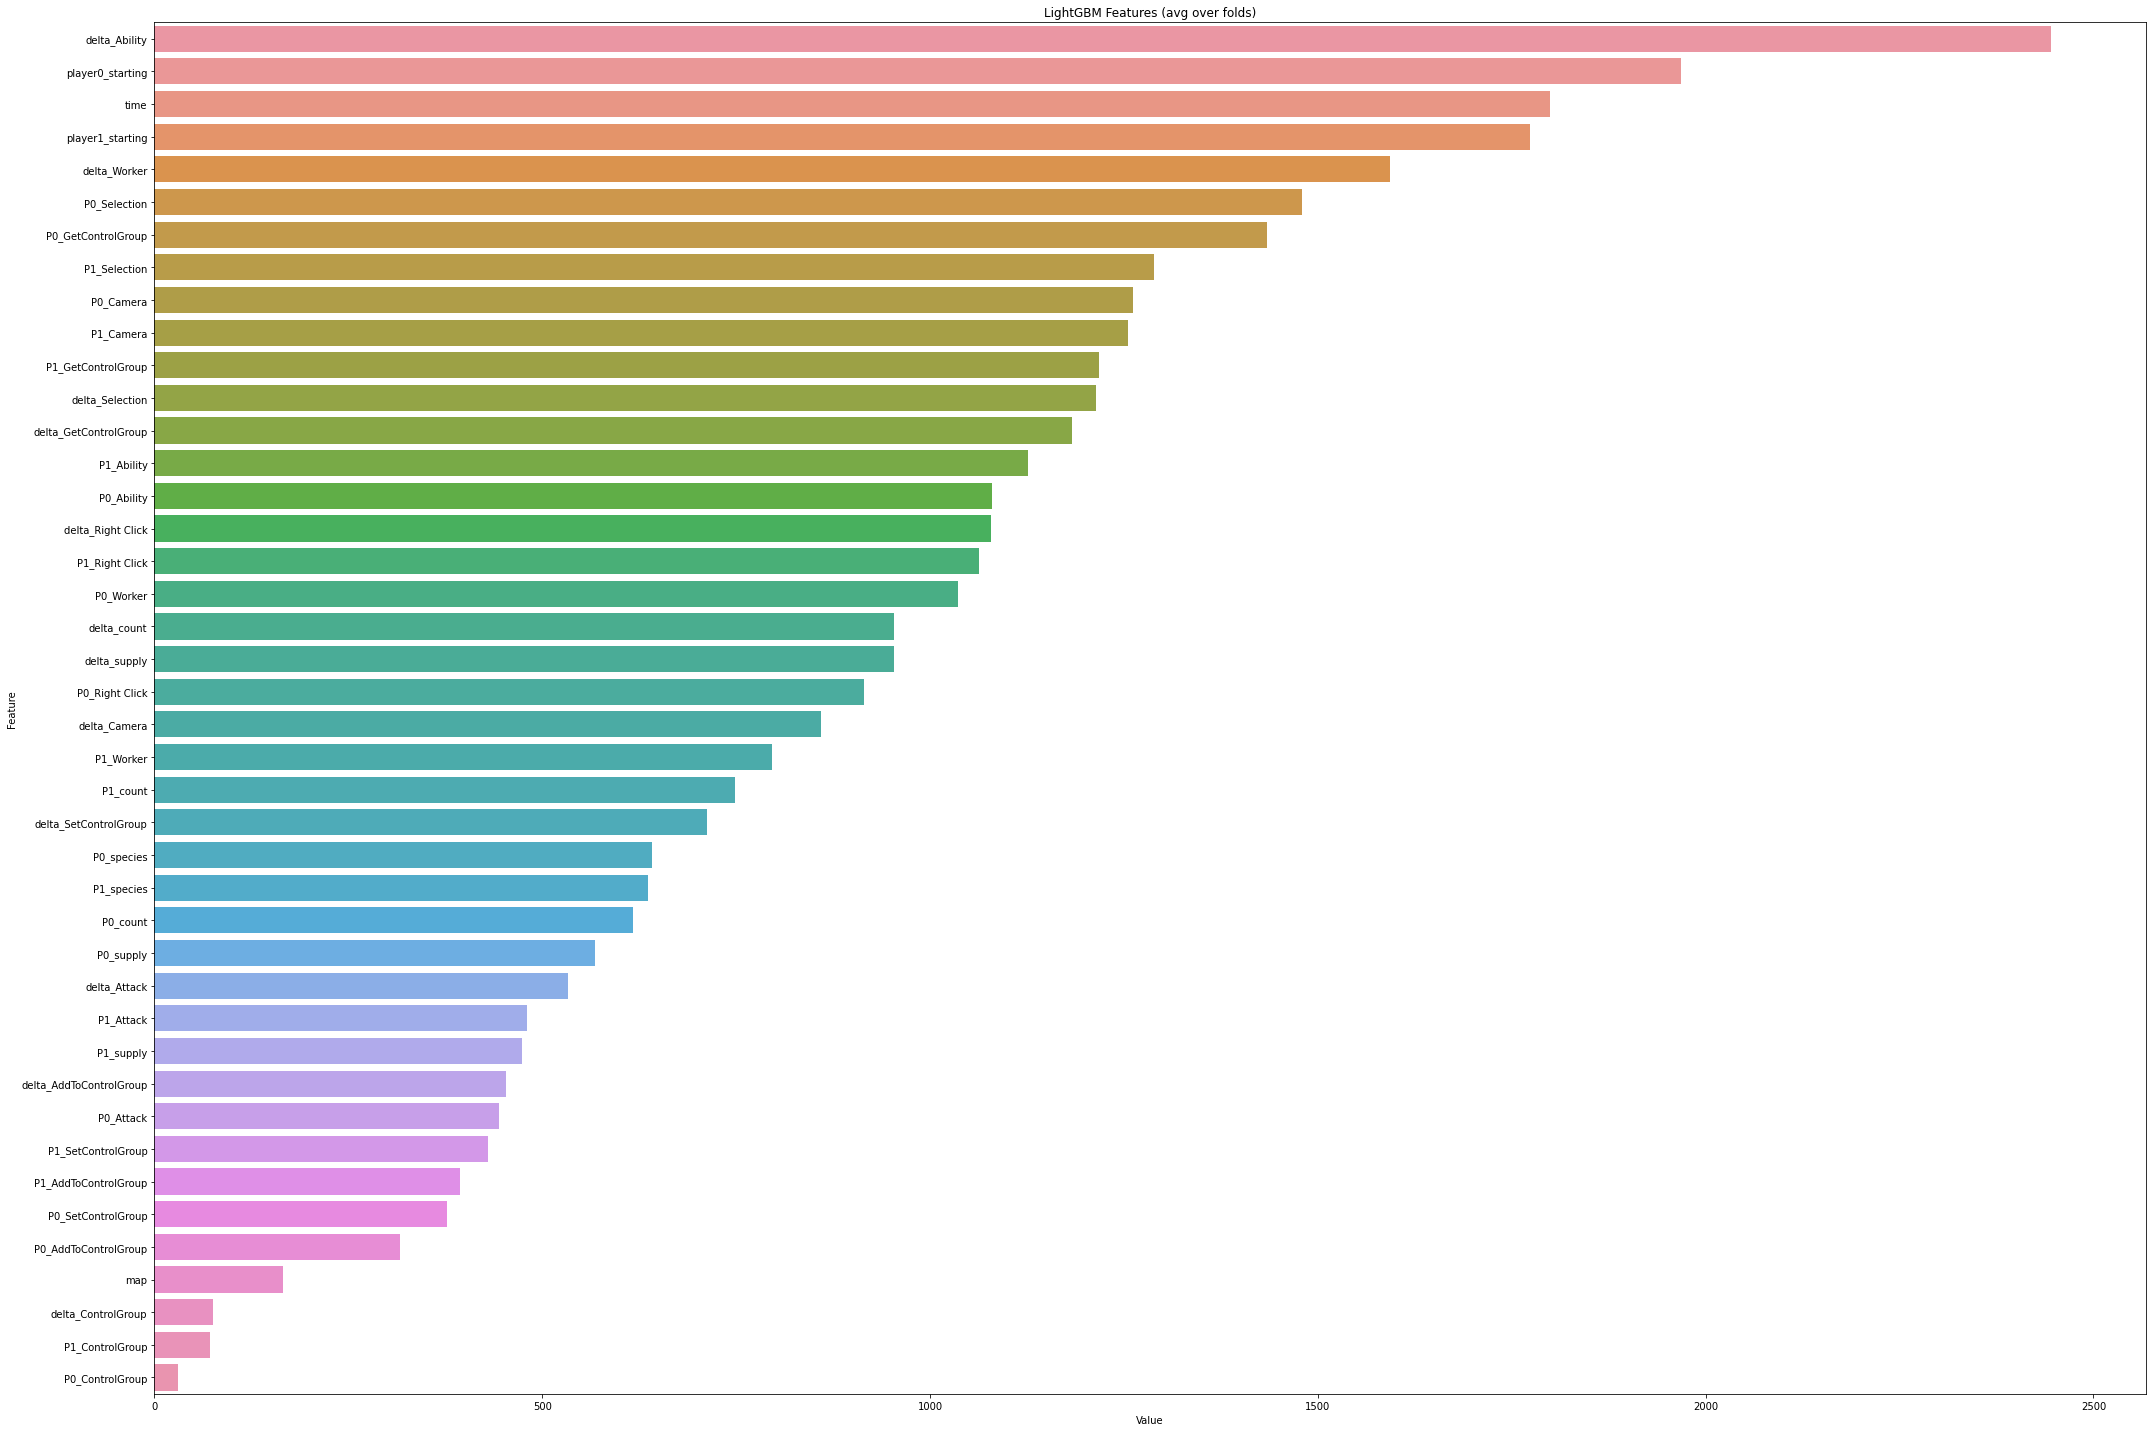

In [27]:
feature_imp = pd.DataFrame(sorted(zip(models[0].feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(30, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [277]:
x_train.to_csv('X_train.csv')

# test에 적용하기 

In [52]:
x_test['P0_Ability'] = a['P0_Ability']
x_test['P1_Ability'] = a['P1_Ability']
x_test['delta_Ability'] = a['P0_Ability'] - a['P1_Ability']

In [203]:
test = pd.read_csv('test.csv')
x_test, _ = data_preparation(test, answer=False)

100%|██████████| 16787/16787 [02:59<00:00, 93.55it/s] 


# 일꾼 뽑기

In [204]:
po =  test[(test['event_contents'].str.contains('TrainSCV') == True) |
            (test['event_contents'].str.contains('TrainProbe') == True) |
            (test['event_contents'].str.contains('MorphDrone') == True)]

In [205]:
count = po.groupby(['game_id','player'])['event_contents'].count()
worker = count.unstack().fillna(0)
worker.rename(columns = {0 : 'P0_Worker'}, inplace = True)
worker.rename(columns = {1 : 'P1_Worker'}, inplace = True)

# Attack 

In [206]:
po =  test[(test['event_contents'].str.contains('Attack') == True)]
count = po.groupby(['game_id','player'])['event_contents'].count()
attack = count.unstack().fillna(0)
attack.rename(columns = {0 : 'P0_Attack'}, inplace = True)
attack.rename(columns = {1 : 'P1_Attack'}, inplace = True)

# 유닛

In [207]:
po =  test[(test['event_contents'].str.contains('Train') == True) |
            (test['event_contents'].str.contains('Warp') == True) |
            (test['event_contents'].str.contains('Morph') == True)]
po =  po[(po['event_contents'].str.contains('MorphOverlord') == False)]
unit = po[po['event'] != 'Selection'].groupby(['game_id','player'])['event_contents'].count()
unit_all = unit.unstack().fillna(0)
unit_all.rename(columns = {0 : 'P0_count'}, inplace = True)
unit_all.rename(columns = {1 : 'P1_count'}, inplace = True)

# 보급

In [208]:
po =  test[(test['event_contents'].str.contains('BuildSupply') == True) |
            (test['event_contents'].str.contains('BuildPylon') == True) |
            (test['event_contents'].str.contains('MorphOverlord') == True)]
count = po.groupby(['game_id','player'])['event_contents'].count()
supply = count.unstack().fillna(0)
supply.rename(columns = {0 : 'P0_supply'}, inplace = True)
supply.rename(columns = {1 : 'P1_supply'}, inplace = True)

In [54]:
#x_test['time'] = np.array(test[test.shift(-1).game_id != test.game_id].time)

In [209]:
x_test = pd.merge(x_test,unit_all, on = 'game_id', how = 'left')
x_test.fillna(0,inplace= True)
x_test['delta_count'] = x_test['P0_count'] - x_test['P1_count'] 

In [210]:
x_test = pd.merge(x_test,attack, on = 'game_id', how = 'left')
x_test.fillna(0,inplace= True)
x_test['delta_Attack'] = x_test['P0_Attack'] - x_test['P1_Attack'] 

In [60]:
x_test['P0_species'] = x_test["P0_species"].astype('category')
x_test['P1_species'] = x_test["P1_species"].astype('category')

In [211]:
x_test = pd.merge(x_test,worker, on = 'game_id', how = 'left')
x_test.fillna(0,inplace= True)
x_test['delta_Worker'] = x_test['P0_Worker'] - x_test['P1_Worker'] 

In [212]:
x_test = pd.merge(x_test,supply, on = 'game_id', how = 'left')
x_test.fillna(0,inplace= True)
x_test['delta_supply'] = x_test['P0_supply'] - x_test['P1_supply']

In [213]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16787 entries, 38872 to 55658
Data columns (total 38 columns):
P0_species                 16787 non-null int64
P0_Ability                 16787 non-null float64
P0_AddToControlGroup       16787 non-null float64
P0_Camera                  16787 non-null float64
P0_ControlGroup            16787 non-null float64
P0_GetControlGroup         16787 non-null float64
P0_Right Click             16787 non-null float64
P0_Selection               16787 non-null float64
P0_SetControlGroup         16787 non-null float64
P1_species                 16787 non-null int64
P1_Ability                 16787 non-null float64
P1_AddToControlGroup       16787 non-null float64
P1_Camera                  16787 non-null float64
P1_ControlGroup            16787 non-null float64
P1_GetControlGroup         16787 non-null float64
P1_Right Click             16787 non-null float64
P1_Selection               16787 non-null float64
P1_SetControlGroup         16787 non-null

In [214]:
df_test = pd.DataFrame(test.game_id.unique(), columns=['game_id'])
df_test.index = df_test.game_id
df_test = df_test.drop(['game_id'], axis = 1)
df_test_p0 = test[(test.event=='Camera')&(test.player==0)]
df_test_p0 = df_test_p0[df_test_p0.shift(1).game_id!=df_test_p0.game_id] # 쉬프트를 이용하여 각 게임의 첫번째 데이터 찾기
df_test_p0 = df_test_p0.iloc[:, [0,5]].rename({'event_contents':'player0_starting'}, axis = 1)
df_test_p0.index = df_test_p0['game_id']
df_test_p0 = df_test_p0.drop(['game_id'], axis=1)
df_test = pd.merge(df_test, df_test_p0, on='game_id', how='left')
del df_test_p0

df_test_p1 = test[(test.event=='Camera')&(test.player==1)]
df_test_p1 = df_test_p1[df_test_p1.shift(1).game_id!=df_test_p1.game_id]
df_test_p1 = df_test_p1.iloc[:, [0,5]].rename({'event_contents':'player1_starting'}, axis = 1)
df_test_p1.index = df_test_p1['game_id']
df_test_p1 = df_test_p1.drop(['game_id'], axis=1)
df_test = pd.merge(df_test, df_test_p1, on='game_id', how='left')
del df_test_p1

In [222]:
df_test

,player0_starting,player1_starting,player0_x,player0_y,player1_x,player1_y
game_id,,,,,,
38872,"22.25, 81.5078125","120.25, 153.83984375",22.25,81.507812,120.25,153.839844
38873,"24.75, 128.0078125","151.25, 20.5078125",24.75,128.007812,151.25,20.507812
38874,"151.25, 20.5078125","24.75, 128.0078125",151.25,20.507812,24.75,128.007812
38875,"152.25, 142.0078125","31.75, 22.5078125",152.25,142.007812,31.75,22.507812
38876,"135.25, 31.5078125","22.25, 81.5078125",135.25,31.507812,22.25,81.507812
...,...,...,...,...,...,...
55654,"22.25, 81.5078125","135.25, 31.5078125",22.25,81.507812,135.25,31.507812
55655,"120.25, 153.83984375","135.25, 31.5078125",120.25,153.839844,135.25,31.507812
55656,"24.75, 128.0078125","151.25, 20.5078125",24.75,128.007812,151.25,20.507812


In [216]:
df_test['player0_starting'] = df_test.player0_starting.str.split('(').str[1]
df_test['player0_starting'] = df_test.player0_starting.str.split(')').str[0]
split_xy = df_test.player0_starting.str.split(',')
df_test['player0_x'] = split_xy.str[0].astype('float')
df_test['player0_y'] = split_xy.str[1].astype('float')
del split_xy

df_test['player1_starting'] = df_test.player1_starting.str.split('(').str[1]
df_test['player1_starting'] = df_test.player1_starting.str.split(')').str[0]
split_xy = df_test.player1_starting.str.split(',')
df_test['player1_x'] = split_xy.str[0].astype('float')
df_test['player1_y'] = split_xy.str[1].astype('float')
del split_xy

location_p0 = df_test.loc[:, ['player0_x', 'player0_y']]
location_p0 = location_p0.rename({'player0_x':'location_x', 'player0_y':'location_y'}, axis=1)

location_p1 = df_test.loc[:, ['player1_x', 'player1_y']]
location_p1 = location_p1.rename({'player1_x':'location_x', 'player1_y':'location_y'}, axis=1)
location_p1.index += location_p0.index[-1]+1

location = pd.concat([location_p0, location_p1])
location = location.dropna()
del location_p0, location_p1

In [227]:
location_p0 = df_test.loc[:, ['player0_x', 'player0_y']]
location_p0 = location_p0.rename({'player0_x':'location_x', 'player0_y':'location_y'}, axis=1)

location_p1 = df_test.loc[:, ['player1_x', 'player1_y']]
location_p1 = location_p1.rename({'player1_x':'location_x', 'player1_y':'location_y'}, axis=1)
location_p1.index += location_p0.index[-1]+1

location = pd.concat([location_p0, location_p1])
location = location.dropna()
#del location_p0, location_p1

In [229]:
location

,location_x,location_y
game_id,,
38872,22.25,81.507812
38873,24.75,128.007812
38874,151.25,20.507812
38875,152.25,142.007812
38876,135.25,31.507812
...,...,...
111313,135.25,31.507812
111314,135.25,31.507812
111315,151.25,20.507812


In [217]:
df_test.player0_starting.value_counts().head(20)

145.25, 21.5078125          1368
22.75, 147.0078125          1332
151.25, 20.5078125          1325
24.75, 128.0078125          1256
24.75, 137.0078125          1153
31.75, 22.5078125           1150
163.25, 18.5078125          1139
127.25, 27.5078125          1130
152.25, 142.0078125         1100
28.0, 18.5078125            1084
140.0, 162.0078125          1005
36.75, 122.0078125           949
135.25, 31.5078125           550
22.25, 81.5078125            540
120.25, 153.83984375         529
36.74609375, 122.0078125     113
22.75, 147.01171875           31
151.25, 20.51171875           30
28.0, 18.51171875             27
24.75, 128.01171875           24
Name: player0_starting, dtype: int64

In [221]:
location

,location_x,location_y
game_id,,
38872,22.25,81.507812
38873,24.75,128.007812
38874,151.25,20.507812
38875,152.25,142.007812
38876,135.25,31.507812
...,...,...
111313,135.25,31.507812
111314,135.25,31.507812
111315,151.25,20.507812


In [230]:
kmeans_clst = KMeans(n_clusters=15).fit(location)
location['starting'] = kmeans_clst.labels_+1

In [233]:
for cluster in range(15):
    point = location[location.starting==cluster+1]
    loc = point.loc[:,['location_x', 'location_y']]
    del point
    loc['center_x'] = kmeans_clst.cluster_centers_[cluster][0]
    loc['center_y'] = kmeans_clst.cluster_centers_[cluster][1]
    distance = np.sqrt(np. square(loc.location_x - loc.center_x) + np.square(loc.location_y - loc.center_y))
    location.loc[loc.index, 'distance'] = distance
    del loc
idx = location[location.distance>5].index
location.loc[idx, 'starting'] = 0
del idx

In [234]:
location

,location_x,location_y,starting,distance
game_id,,,,
38872,22.25,81.507812,6,0.152198
38873,24.75,128.007812,12,0.021451
38874,151.25,20.507812,14,0.035709
38875,152.25,142.007812,7,0.049527
38876,135.25,31.507812,5,0.153903
...,...,...,...,...
111313,135.25,31.507812,5,0.153903
111314,135.25,31.507812,5,0.153903
111315,151.25,20.507812,14,0.035709


In [235]:
df_test['player0_starting'] = location.loc[df_test.index, 'starting']
location.index -= (df_test.index[-1]+1)
df_test['player1_starting'] = location.loc[df_test.index, 'starting']
del location

In [236]:
df_test

,player0_starting,player1_starting,player0_x,player0_y,player1_x,player1_y
game_id,,,,,,
38872,6.0,10.0,22.25,81.507812,120.25,153.839844
38873,12.0,14.0,24.75,128.007812,151.25,20.507812
38874,14.0,12.0,151.25,20.507812,24.75,128.007812
38875,7.0,15.0,152.25,142.007812,31.75,22.507812
38876,5.0,6.0,135.25,31.507812,22.25,81.507812
...,...,...,...,...,...,...
55654,6.0,5.0,22.25,81.507812,135.25,31.507812
55655,10.0,5.0,120.25,153.839844,135.25,31.507812
55656,12.0,14.0,24.75,128.007812,151.25,20.507812


In [304]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38872 entries, 0 to 38871
Data columns (total 2 columns):
player0_starting    38872 non-null float64
player1_starting    38872 non-null float64
dtypes: float64(2)
memory usage: 911.1 KB


In [305]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16787 entries, 38872 to 55658
Data columns (total 2 columns):
player0_starting    16787 non-null float64
player1_starting    16787 non-null float64
dtypes: float64(2)
memory usage: 393.4 KB


In [238]:
# 불필요한 컬럼 삭제
df_test = df_test.drop(['player0_x', 'player0_y', 'player1_x', 'player1_y'], axis = 1)
df_test = df_test.fillna(0)

In [303]:
len(df_test['player1_starting'].unique())

16

In [241]:
df_test1 = df_test.reset_index()

In [261]:
df_test1.drop(columns= ['game_id'],inplace =True )

In [308]:
couple = df_test1[df_test1.player0_starting == 4].player1_starting.value_counts()

In [312]:
df_train

,player0_starting,player1_starting
game_id,,
0,13.0,5.0
1,1.0,15.0
2,2.0,12.0
3,7.0,8.0
4,3.0,11.0
...,...,...
38867,5.0,13.0
38868,15.0,1.0
38869,2.0,12.0


In [315]:
df_test1 = pd.concat([df_train,df_test])

In [316]:
df_test1

,player0_starting,player1_starting
game_id,,
0,13.0,5.0
1,1.0,15.0
2,2.0,12.0
3,7.0,8.0
4,3.0,11.0
...,...,...
55654,6.0,5.0
55655,10.0,5.0
55656,12.0,14.0


In [324]:
map_list = []
for point in range(1,16):
    couple = df_test1[df_test1.player0_starting == point].player1_starting.value_counts()
    if couple[couple.index[1]]<100:
        map_list.append([point, couple.index[0], 999])
    else:
        map_list.append([point, couple.index[0], couple.index[1]])
map_list = np.sort(map_list, axis = 1)
map_list = np.unique(map_list, axis = 0)

In [325]:
for m in map_list:
    idx = df_test1[(df_test1.player0_starting == 0)&((df_test1.player1_starting == m[0])|(df_test1.player1_starting == m[2]))].index
    df_test1.loc[idx, 'player0_starting'] = m[1]
    del idx
    idx = df_test1[(df_test1.player0_starting == 0)&((df_test1.player1_starting == m[1])|(df_test1.player1_starting == m[2]))].index
    df_test1.loc[idx, 'player0_starting'] = m[0]
    del idx
    
    idx = df_test1[(df_test1.player1_starting == 0)&((df_test1.player0_starting == m[0])|(df_test1.player0_starting == m[2]))].index
    df_test1.loc[idx, 'player1_starting'] = m[1]
    del idx
    idx = df_test1[(df_test1.player1_starting == 0)&((df_test1.player0_starting == m[1])|(df_test1.player0_starting == m[2]))].index
    df_test1.loc[idx, 'player1_starting'] = m[0]
    del idx

In [326]:
for map_num, m in enumerate(map_list):
    idx = df_test1[(df_test1.player0_starting == m[0])|(df_test1.player0_starting == m[1])|(df_test1.player0_starting == m[2])].index
    df_test1.loc[idx, 'map'] = map_num
del idx, map_list

In [321]:
df_test

,player0_starting,player1_starting,map
game_id,,,
38872,6.0,10.0,11.0
38873,12.0,14.0,13.0
38874,14.0,12.0,13.0
38875,7.0,15.0,12.0
38876,5.0,6.0,10.0
...,...,...,...
55654,6.0,5.0,11.0
55655,10.0,5.0,13.0
55656,12.0,14.0,13.0


In [331]:
x_test = pd.merge(x_test,df_test, on ='game_id', how = 'left')

In [25]:
x_test['player0_starting'] = x_test['player0_starting'].astype(int) 
x_test['player1_starting'] = x_test['player0_starting'].astype(int) 
x_test['map'] = x_test['map'].astype(int) 

In [26]:
x_test['player0_starting'] = x_test['player0_starting'].astype('category')
x_test['player1_starting'] = x_test['player1_starting'].astype('category')
x_test['map'] = x_test['map'].astype('category')
x_test['P0_species'] = x_test['P0_species'].astype('category')
x_test['P1_species'] = x_test['P1_species'].astype('category')

In [23]:
x_test = pd.read_csv('X_test.csv',index_col = 'game_id')

In [27]:
x_test_time = x_test['time']

In [28]:
del x_test['time']
x_test['time'] = x_test_time

In [32]:
pred

array([[0.37435336, 0.62564664],
       [0.5711053 , 0.4288947 ],
       [0.40757074, 0.59242926],
       ...,
       [0.3238697 , 0.6761303 ],
       [0.39706469, 0.60293531],
       [0.43176175, 0.56823825]])

In [35]:
submission = pd.read_csv('/home/gunwook/sample_submission.csv', index_col=0)
submission['winner'] = submission['winner'] + pred[:,1]
submission.to_csv('submission_soft.csv')

In [36]:
submission.head()

,winner
game_id,
38872,0.625647
38873,0.428895
38874,0.592429
38875,0.192930
38876,0.545493


In [31]:
preds = []
for model in models:
    pred = model.predict_proba(x_test)[:, 1]
    preds.append(pred)
pred = np.mean(preds, axis=0)

submission = pd.read_csv('/home/gunwook/sample_submission.csv', index_col=0)
submission['winner'] = submission['winner'] + pred
submission.to_csv('submission.csv')
submission.head()

,winner
game_id,
38872,0.492768
38873,0.413605
38874,0.579027
38875,0.265999
38876,0.410061


In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 1000,  
    'max_depth': 10,  
    'min_child_samples': 100,  
    'max_bin': 120,  
    'subsample': 0.7,  
    'subsample_freq': 1,  
    'colsample_bytree': 0.7,  
    'min_child_weight': 0,  
    'subsample_for_bin': 200000,  
    'min_split_gain': 0,  
    'reg_alpha': 0,  
    'reg_lambda': 0,  
    'verbose': 0,
    'num_class' : 198,
    'seed' : 40
    }

In [335]:
x_test.to_csv('x_test.csv')